In [1]:
import numpy as np
from scipy.stats import gamma, norm,multivariate_normal

#from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import TwoSlopeNorm as TSNorm

seed = 42 # for reproducibility
n_iters =10000 


## Deriving the formulas and implementation

- Derive a Gibbs sampler for the ARD regression model.
- Implement the Gibbs sampler.
- Compute the unnormalized log-posterior

In [2]:
class BayesianRegression(BaseEstimator, RegressorMixin):
    """'Standard' Bayesian linear regression (same as in Exercise 9)."""
    def __init__(self, a0:float, b0:float,fit_intercept:bool=False, n_iter = 1000, random_state:int = 0, beta:float = 1.0, alpha:float = 1.0):
        self.a0 = a0
        self.b0 = b0
        self.weights = None
        self.alpha = alpha
        self.beta = beta
        self.n_iter = n_iter
        self.random_state = random_state
        self.fit_intercept = fit_intercept
     
    

    def _sample_w(self,y:np.ndarray,X:np.ndarray, beta:float ,alpha:float):
        N,D = X.shape
        Sigma_w_inv = beta * X.T @ X + np.eye(D)*alpha
        Sigma_w = np.linalg.inv(Sigma_w_inv)
        mu_w = beta * Sigma_w @ X.T @ y 

        return multivariate_normal.rvs(mean = mu_w, cov = Sigma_w)

    
    def _sample_beta(self, y:np.ndarray,X:np.ndarray,w:np.ndarray):
        n,_ = X.shape
        a = self.a0 + n/2
        y_hat = X@w.T
        b =self.b0+ 0.5*(y - y_hat.T) @(y - y_hat)
        return gamma.rvs(a=a, scale=1/b)
    
    def _gibbs_sampler(self, y, X, n_iter:int = 1000,verbose:int = None):
        N,D = X.shape
        
        w_samples = np.zeros((n_iter, D))
        beta_samples = np.zeros(n_iter)
 
        log_probs = np.zeros(n_iter)
        if verbose is None:
            verbose = np.inf
        for i in range(n_iter):
            self.weights = self._sample_w(y,X,self.beta, self.alpha)

            self.beta = self._sample_beta(y,X,self.weights)
            
            w_samples[i] = self.weights
            beta_samples[i] = self.beta
            log_probs[i] = self._compute_unnormalized_log_posterior(y,X)
            if i % verbose ==0:
                print(f"Iteration {i} - unnormalized_log_posterior: {log_probs[i]:.2f}")


        return w_samples, beta_samples, log_probs


    def _compute_unnormalized_log_posterior(self, y,X): 
        N,D = X.shape
        epsilon = 1e-7
        y_pred = X@self.weights.T
        log_p_w = multivariate_normal.logpdf(self.weights, mean=np.zeros(D), cov= np.eye(D)/(self.alpha+epsilon))
        log_p_y = np.sum(norm.logpdf(y, loc=y_pred, scale=np.sqrt(1/(self.beta+epsilon))))
        log_p_beta = gamma.logpdf(self.beta, a=self.a0, scale=1/self.b0) 
        return log_p_y + log_p_w +log_p_beta
    
   

    def fit(self, X:np.ndarray, y:np.ndarray, verbose:int = None):
        np.random.seed(self.random_state)
        # Ensuring X is a 2D array
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)

        if self.fit_intercept:
            X = np.hstack([np.ones((X.shape[0],1)),X])
        N,D = X.shape
        
        self.weights = np.zeros(D,dtype=float)

        w_samples, beta_samples, log_probs = self._gibbs_sampler(y,X,self.n_iter,verbose)
        burn_in = self.n_iter//2
        
        self.w_samples= w_samples
        self.beta_samples= beta_samples
        self.log_probs= log_probs

        self.weights = np.mean(w_samples[burn_in:,:], axis=0)
        self.weights_var = np.var(w_samples[burn_in:,:], axis=0)
        return w_samples, beta_samples,log_probs
    
    def predict(self, X:np.ndarray):
        if self.fit_intercept:
            X = np.hstack([np.ones((X.shape[0],1)),X])
        return X@self.weights.T
    
    def sample_from_posterior_predictive_distribution(self,X ,n_functions:int = 30, thinning:int = 1):
        thinning = max(thinning,1)
        thinning = min(thinning,self.n_iter//2)

        if self.fit_intercept:
            X = np.hstack([np.ones((X.shape[0],1)),X])
        
        inds = np.concatenate((np.arange(start = self.n_iter//2, stop = self.n_iter, step=thinning),np.array([self.n_iter-1])))

        sampled_inds = np.random.choice(inds, replace=True, size = n_functions)

        N, D = X.shape
        ys = np.zeros((N, n_functions))
        for i, ind in enumerate(sampled_inds):
            y = np.random.normal(X@self.w_samples[ind,:], np.sqrt(1/self.beta_samples[ind]), size=N ) 
            ys[:,i] = y

        return ys


    


class ARDRegression(BaseEstimator, RegressorMixin):
    """Bayesian linear regression with ARD priors."""
    def __init__(self, a0:float, b0:float, c0:float, d0:float, fit_intercept:bool=False, n_iter = 1000,random_state:int = 0,beta:float = 1.0):
        self.a0 = a0
        self.b0 = b0
        self.c0 = c0
        self.d0 = d0
        self.weights = None
        self.alphas = None
        self.beta = beta
        self.n_iter = n_iter
        self.random_state = random_state
        self.fit_intercept = fit_intercept 
     
    

    def _sample_w(self,y:np.ndarray,X:np.ndarray, beta:float ,alphas:np.ndarray):
        # https://www.youtube.com/watch?v=nrd4AnDLR3U
        Sigma_w_inv = beta * X.T @ X + np.diag(alphas) 
        Sigma_w = np.linalg.inv(Sigma_w_inv)
        mu_w = beta * Sigma_w @ X.T @ y 
        return multivariate_normal.rvs(mean = mu_w, cov = Sigma_w)

    def _sample_beta(self, y:np.ndarray,X:np.ndarray,w:np.ndarray):
        n,_ = X.shape
        a = self.a0 + n/2
        y_hat = X@w.T
        b =self.b0+ 0.5*(y - y_hat.T) @(y - y_hat)
        return gamma.rvs(a=a, scale=1/b)
    
    def _sample_alpha(self, w:np.ndarray):
        D = len(w)
        alphas_ = np.zeros(D)
        for j in range(D):
            c = self.c0 + 0.5
            d = self.d0 + 0.5 * w[j]**2
            alphas_[j] = gamma.rvs(a=c, scale = 1/d)
        return alphas_
    

    def _gibbs_sampler(self, y, X, n_iter:int = 1000,verbose:int = None):
        N,D = X.shape
        w_samples = np.zeros((n_iter, D))
        beta_samples = np.zeros(n_iter)
        alpha_samples = np.zeros((n_iter,D))
        log_probs = np.zeros(n_iter)
   
        if verbose is None:
            verbose = np.inf
        for i in range(n_iter):
            self.weights = self._sample_w(y, X, self.beta, self.alphas)

            self.beta = self._sample_beta(y,X,self.weights)
            self.alphas = self._sample_alpha(self.weights)


            w_samples[i] = self.weights
            beta_samples[i] = self.beta
            alpha_samples[i] = self.alphas
            log_probs[i] = self._compute_unnormalized_log_posterior(y,X)
            if i % verbose ==0:
                print(f"Iteration {i} - unnormalized_log_posterior: {log_probs[i]:.2f}")


        return w_samples, beta_samples, alpha_samples, log_probs


    def _compute_unnormalized_log_posterior(self, y,X): 
        N,D = X.shape
        y_pred = X@self.weights.T
        epsilon = 1e-7
        log_p_w = multivariate_normal.logpdf(self.weights, mean=np.zeros(D), cov= np.diag(1/(self.alphas+epsilon)))
        log_p_y = np.sum(norm.logpdf(y, loc=y_pred, scale=np.sqrt(1/((self.beta+epsilon)))))
        log_prior_alphas = np.sum(gamma.logpdf(self.alphas, a=self.c0, scale=1/self.d0))
        log_p_beta = gamma.logpdf(self.beta, a=self.a0, scale=1/self.b0) 
        return log_p_y + log_p_w + log_prior_alphas+log_p_beta

    def fit(self, X:np.ndarray, y:np.ndarray, verbose:int = None):
        np.random.seed(self.random_state)
        # Ensuring X is a 2D array
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        if self.fit_intercept:
            X = np.hstack([np.ones((X.shape[0],1)),X])

        N,D = X.shape
        
        self.weights = np.zeros(D,dtype=float)
        self.alphas = np.ones(D,dtype=float)

        w_samples, beta_samples, alpha_samples, log_probs = self._gibbs_sampler(y,X,self.n_iter,verbose)
        burn_in = self.n_iter//2
        
        self.weights = np.mean(w_samples[burn_in:,:], axis=0)
        self.weights_var = np.var(w_samples[burn_in:,:], axis=0)
        self.w_samples = w_samples
        self.beta_samples = beta_samples
        self.alpha_samples = alpha_samples
        return w_samples, beta_samples, alpha_samples, log_probs
    
    def predict(self, X:np.ndarray):
        if self.fit_intercept:
            X = np.hstack([np.ones((X.shape[0],1)),X])
        return X@self.weights.T
    

    def sample_from_posterior_predictive_distribution(self,X ,n_functions:int = 30, thinning:int = 1):
        thinning = max(thinning,1)
        thinning = min(thinning,self.n_iter//2)
        if self.fit_intercept:
            X = np.hstack([np.ones((X.shape[0],1)),X])
        inds = np.concatenate((np.arange(start = self.n_iter//2, stop = self.n_iter, step=thinning),np.array([self.n_iter-1])))

        sampled_inds = np.random.choice(inds, replace=True, size = n_functions)

        N, D = X.shape
        ys = np.zeros((N, n_functions))
        for i, ind in enumerate(sampled_inds):
            y = np.random.normal(X@self.w_samples[ind,:], np.sqrt(1/self.beta_samples[ind]) , size=N )  
            ys[:,i] = y

        return ys
            


        




In [3]:
def simulate_data(n_samples:int = 100, n_features:int=10, n_informative:int=5, bias:bool=False, noise:float=1.0, coef:bool=True, random_state:int=0):
    n_informative = np.clip(n_informative, a_max=n_features, a_min=0)
    np.random.seed(random_state)
    intercept  = 0.0
    weights = np.random.uniform(-20,20,size=n_features)
    ind_irrelant = np.random.choice(len(weights)-bias, replace=False,size=n_features - n_informative) + bias
    weights[ind_irrelant] = 0.0

    X = np.random.uniform(-10,10, (n_samples,n_features))
    if bias:
        intercept = np.random.uniform(-20,20)
 
    y = intercept + X@weights + np.random.normal( loc = 0,scale= noise, size=n_samples) 

    if coef:
        return X,y, intercept, weights
    return X,y
    

## Sanity Check

- Simple experiments to see if things make sense. 

In [4]:
np.random.seed(seed)

N,D = 1000, 2
# Simulate data
X, y,_, coef = simulate_data(n_samples=N, n_features=D, n_informative=1, noise=20, coef=True, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

print(X_train.shape,X_test.shape )

(500, 2) (500, 2)


In [5]:

blr = BayesianRegression(a0=0.1,b0= 0.1,n_iter=n_iters, random_state=seed,beta=1,alpha=0.1)

blr_w_samples, blr_beta_samples, blr_log_probs = blr.fit(X_train,y_train,verbose=500)

blr.weights, blr.weights_var


Iteration 0 - unnormalized_log_posterior: -2209.89
Iteration 500 - unnormalized_log_posterior: -2214.38
Iteration 1000 - unnormalized_log_posterior: -2210.73
Iteration 1500 - unnormalized_log_posterior: -2215.13
Iteration 2000 - unnormalized_log_posterior: -2210.18
Iteration 2500 - unnormalized_log_posterior: -2210.03
Iteration 3000 - unnormalized_log_posterior: -2209.87
Iteration 3500 - unnormalized_log_posterior: -2210.15
Iteration 4000 - unnormalized_log_posterior: -2212.20
Iteration 4500 - unnormalized_log_posterior: -2210.31
Iteration 5000 - unnormalized_log_posterior: -2210.10
Iteration 5500 - unnormalized_log_posterior: -2211.47
Iteration 6000 - unnormalized_log_posterior: -2211.01
Iteration 6500 - unnormalized_log_posterior: -2210.76
Iteration 7000 - unnormalized_log_posterior: -2210.42
Iteration 7500 - unnormalized_log_posterior: -2211.71
Iteration 8000 - unnormalized_log_posterior: -2211.33
Iteration 8500 - unnormalized_log_posterior: -2212.50
Iteration 9000 - unnormalized_lo

(array([-5.03495683,  0.20478208]), array([0.02404913, 0.02677564]))

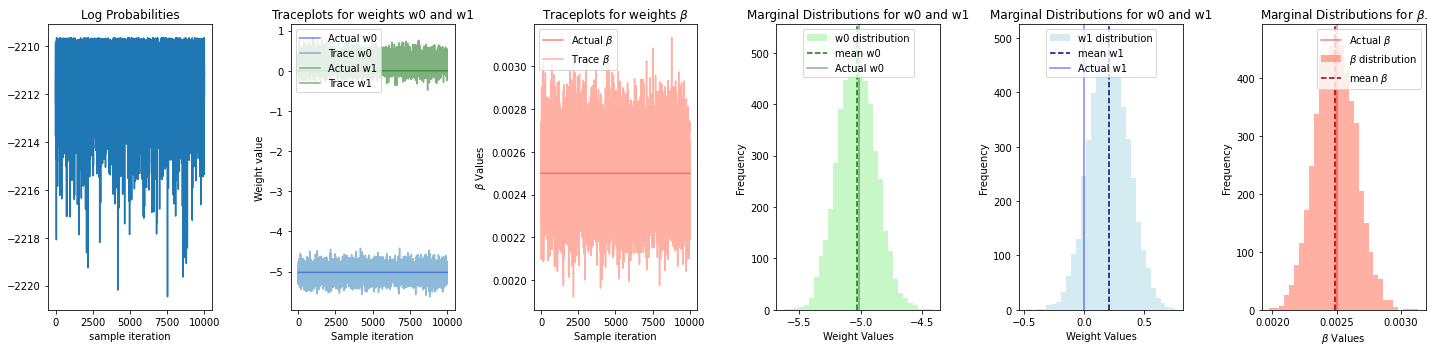

In [6]:
start = 0

x_values = range(start, n_iters)

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 6, figsize=(20, 5))  # Adjust figsize as needed

# Plot for log probabilities
axs[0].plot(x_values, blr_log_probs[start:])
axs[0].set_title('Log Probabilities')
axs[0].set_xlabel("sample iteration")




# Traceplot for weight 0
axs[1].plot(x_values, [coef[0]] * len(x_values), label='Actual w0', alpha=0.5, color='b')
axs[1].plot(x_values, blr_w_samples[start:, 0], label='Trace w0', alpha=0.5)

# Traceplot for weight 1 on the same plot
axs[1].plot(x_values, [coef[1]] * len(x_values), label='Actual w1', alpha=0.5, color='green')
axs[1].plot(x_values, blr_w_samples[start:, 1], label='Trace w1', alpha=0.5, color='darkgreen')

axs[1].set_title('Traceplots for weights w0 and w1')
axs[1].legend(loc="upper left")
axs[1].set_xlabel("Sample iteration")
axs[1].set_ylabel("Weight value")

# ==============================================================



# Traceplot for beta 

axs[2].plot(x_values, [1/(20**2)] * len(x_values), label=r'Actual $\beta$', alpha=0.5, color='r')
axs[2].plot(x_values, blr_beta_samples[start:], alpha=0.5, label=r'Trace $\beta$', color='tomato')
axs[2].set_title(r'Traceplots for weights $\beta$')
axs[2].legend(loc="upper left")
axs[2].set_xlabel("Sample iteration")
axs[2].set_ylabel(r"$\beta$ Values")

# ==============================================================
burn_in = n_iters//2


axs[3].hist(blr_w_samples[burn_in:, 0], alpha=0.5, color='lightgreen', label='w0 distribution', bins=30)
axs[3].axvline(np.mean(blr_w_samples[burn_in:, 0]), color='green', linestyle='--', label='mean w0')


# Actual mean lines for both w0 
axs[3].axvline(coef[0], color='darkgreen', linestyle='-', label='Actual w0', alpha=0.5)


axs[3].set_title('Marginal Distributions for w0 and w1')
axs[3].legend(loc="upper center")
axs[3].set_xlabel("Weight Values")
axs[3].set_ylabel("Frequency")
#axs[2].set_xlim(-1, max(np.max(blr_w_samples[burn_in:, 0]), np.max(blr_w_samples[burn_in:, 1])) + 0.5)




# Marginal distribution for w1 with its mean line, in the same plot
axs[4].hist(blr_w_samples[burn_in:, 1], alpha=0.5, color='lightblue', label='w1 distribution', bins=30)
axs[4].axvline(np.mean(blr_w_samples[burn_in:, 1]), color='darkblue', linestyle='--', label='mean w1')

# Actual mean lines for  w1
axs[4].axvline(coef[1], color='b', linestyle='-', label='Actual w1', alpha=0.5)

axs[4].set_title('Marginal Distributions for w0 and w1')
axs[4].legend(loc="upper center")
axs[4].set_xlabel("Weight Values")
axs[4].set_ylabel("Frequency")


# ==============================================================
# Marginal distribution for w0 with its mean line
axs[5].axvline(1/(20**2), label=r'Actual $\beta$', alpha=0.5, color='r')
axs[5].hist(blr_beta_samples[burn_in:], alpha=0.5, color='tomato', label=r'$\beta$ distribution', bins=30)
axs[5].axvline(np.mean(blr_beta_samples[burn_in:]), color='darkred', linestyle='--', label=r'mean $\beta$')





axs[5].set_title(r'Marginal Distributions for $\beta$.')
axs[5].legend(loc="upper right")
axs[5].set_xlabel(r"$\beta$ Values")
axs[5].set_ylabel("Frequency")


# ==============================================================

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("figures\\simulated\\blr_convergence_and_mixing.png",  facecolor='white', transparent=False)
# Show the plot
plt.show()

In [7]:

ard = ARDRegression(a0=0.1,b0= 0.1,c0= 1, d0= 0.01,n_iter = n_iters,random_state=seed)

w_samples, beta_samples, alpha_samples, log_probs = ard.fit(X_train,y_train, verbose=500)

ard.weights, ard.weights_var

Iteration 0 - unnormalized_log_posterior: -2221.29
Iteration 500 - unnormalized_log_posterior: -2217.35
Iteration 1000 - unnormalized_log_posterior: -2219.34
Iteration 1500 - unnormalized_log_posterior: -2218.30
Iteration 2000 - unnormalized_log_posterior: -2217.88
Iteration 2500 - unnormalized_log_posterior: -2218.96
Iteration 3000 - unnormalized_log_posterior: -2216.70
Iteration 3500 - unnormalized_log_posterior: -2218.54
Iteration 4000 - unnormalized_log_posterior: -2217.19
Iteration 4500 - unnormalized_log_posterior: -2218.06
Iteration 5000 - unnormalized_log_posterior: -2218.81
Iteration 5500 - unnormalized_log_posterior: -2220.12
Iteration 6000 - unnormalized_log_posterior: -2216.87
Iteration 6500 - unnormalized_log_posterior: -2217.36
Iteration 7000 - unnormalized_log_posterior: -2219.36
Iteration 7500 - unnormalized_log_posterior: -2220.82
Iteration 8000 - unnormalized_log_posterior: -2221.20
Iteration 8500 - unnormalized_log_posterior: -2216.96
Iteration 9000 - unnormalized_lo

(array([-5.02593722,  0.08111819]), array([0.02450058, 0.01161342]))

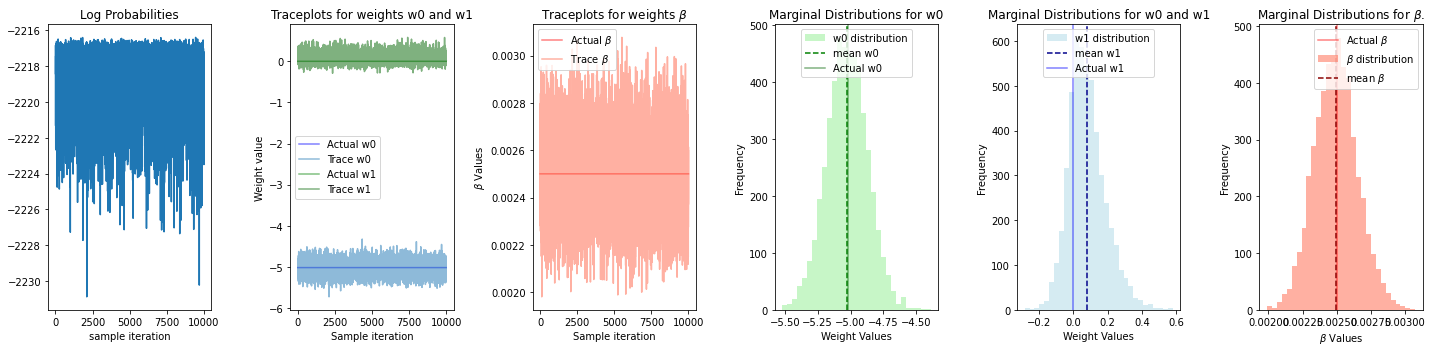

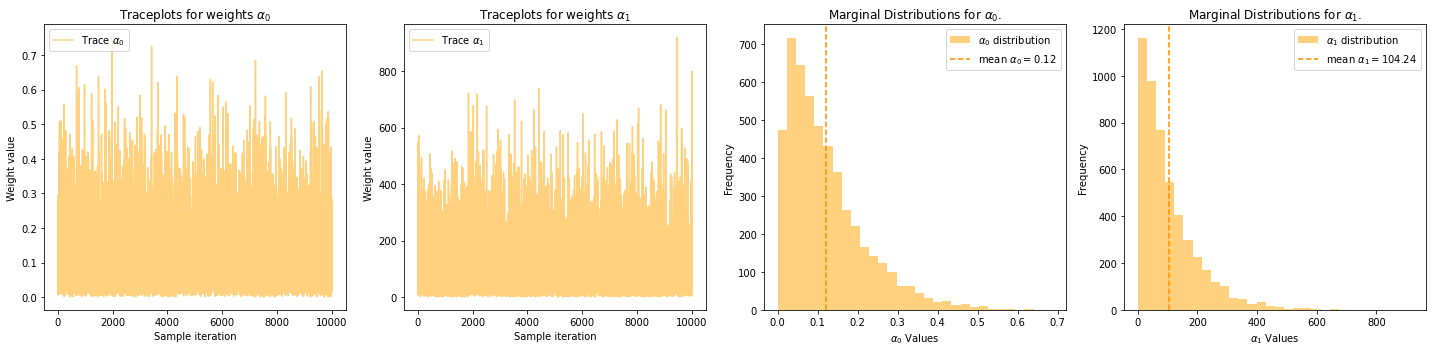

In [8]:
start = 0

x_values = range(start, n_iters)

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 6, figsize=(20, 5))  # Adjust figsize as needed

# Plot for log probabilities
axs[0].plot(x_values, log_probs[start:])
axs[0].set_title('Log Probabilities')
axs[0].set_xlabel("sample iteration")




# Traceplot for weight 0
axs[1].plot(x_values, [coef[0]] * len(x_values), label='Actual w0', alpha=0.5, color='b')
axs[1].plot(x_values, w_samples[start:, 0], label='Trace w0', alpha=0.5)

# Traceplot for weight 1 on the same plot
axs[1].plot(x_values, [coef[1]] * len(x_values), label='Actual w1', alpha=0.5, color='green')
axs[1].plot(x_values, w_samples[start:, 1], label='Trace w1', alpha=0.5, color='darkgreen')

axs[1].set_title('Traceplots for weights w0 and w1')
axs[1].legend(loc="center left")
axs[1].set_xlabel("Sample iteration")
axs[1].set_ylabel("Weight value")

# ==============================================================



# Traceplot for beta 

axs[2].plot(x_values, [1/(20**2)] * len(x_values), label=r'Actual $\beta$', alpha=0.5, color='r')
axs[2].plot(x_values, beta_samples[start:], alpha=0.5, label=r'Trace $\beta$', color='tomato')
axs[2].set_title(r'Traceplots for weights $\beta$')
axs[2].legend(loc="upper left")
axs[2].set_xlabel("Sample iteration")
axs[2].set_ylabel(r"$\beta$ Values")

# ==============================================================
burn_in = n_iters//2


axs[3].hist(w_samples[burn_in:, 0], alpha=0.5, color='lightgreen', label='w0 distribution', bins=30)
axs[3].axvline(np.mean(w_samples[burn_in:, 0]), color='green', linestyle='--', label='mean w0')

# Actual mean lines for both w0 and w1
axs[3].axvline(coef[0], color='darkgreen', linestyle='-', label='Actual w0', alpha=0.5)


axs[3].set_title('Marginal Distributions for w0')
axs[3].legend(loc="upper center")
axs[3].set_xlabel("Weight Values")
axs[3].set_ylabel("Frequency")
#axs[2].set_xlim(-1, max(np.max(blr_w_samples[burn_in:, 0]), np.max(blr_w_samples[burn_in:, 1])) + 0.5)



# Marginal distribution for w1 with its mean line, in the same plot
axs[4].hist(w_samples[burn_in:, 1], alpha=0.5, color='lightblue', label='w1 distribution', bins=30)
axs[4].axvline(np.mean(w_samples[burn_in:, 1]), color='darkblue', linestyle='--', label='mean w1')

# Actual mean lines for  w1
axs[4].axvline(coef[1], color='b', linestyle='-', label='Actual w1', alpha=0.5)

axs[4].set_title('Marginal Distributions for w0 and w1')
axs[4].legend(loc="upper center")
axs[4].set_xlabel("Weight Values")
axs[4].set_ylabel("Frequency")


# ==============================================================
# Marginal distribution for w0 with its mean line
axs[5].axvline(1/(20**2), label=r'Actual $\beta$', alpha=0.5, color='r')
axs[5].hist(beta_samples[burn_in:], alpha=0.5, color='tomato', label=r'$\beta$ distribution', bins=30)
axs[5].axvline(np.mean(beta_samples[burn_in:]), color='darkred', linestyle='--', label=r'mean $\beta$')





axs[5].set_title(r'Marginal Distributions for $\beta$.')
axs[5].legend(loc="upper right")
axs[5].set_xlabel(r"$\beta$ Values")
axs[5].set_ylabel("Frequency")


# ==============================================================

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("figures\\simulated\\ard_convergence_and_mixing.png",  facecolor='white', transparent=False)
# Show the plot
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Adjust figsize as needed

# Traceplot for beta 


axs[0].plot(x_values, alpha_samples[start:,0], alpha=0.5, label=r'Trace $\alpha_0$', color='orange')
axs[0].set_title(r'Traceplots for weights $\alpha_0$')
axs[0].legend(loc="upper left")
axs[0].set_xlabel("Sample iteration")
axs[0].set_ylabel("Weight value")

axs[1].plot(x_values, alpha_samples[start:,1], alpha=0.5, label=r'Trace $\alpha_1$', color='orange')
axs[1].set_title(r'Traceplots for weights $\alpha_1$')
axs[1].legend(loc="upper left")
axs[1].set_xlabel("Sample iteration")
axs[1].set_ylabel("Weight value")



axs[2].hist(alpha_samples[burn_in:,0], alpha=0.5, color='orange', label=r'$\alpha_0$ distribution', bins=30)
axs[2].axvline(np.mean(alpha_samples[burn_in:,0]), color='darkorange', linestyle='--', label=r'mean $\alpha_0=$' + f"{np.mean(alpha_samples[burn_in:,0]):.2f}")

axs[2].set_title(r'Marginal Distributions for $\alpha_0$.')
axs[2].legend(loc="upper right")
axs[2].set_xlabel(r"$\alpha_0$ Values")
axs[2].set_ylabel("Frequency")


axs[3].hist(alpha_samples[burn_in:,1], alpha=0.5, color='orange', label=r'$\alpha_1$ distribution', bins=30)
axs[3].axvline(np.mean(alpha_samples[burn_in:,1]), color='darkorange', linestyle='--', label=r'mean $\alpha_1=$' + f"{np.mean(alpha_samples[burn_in:,1]):.2f}")

axs[3].set_title(r'Marginal Distributions for $\alpha_1$.')
axs[3].legend(loc="upper right")
axs[3].set_xlabel(r"$\alpha_1$ Values")
axs[3].set_ylabel("Frequency")
plt.tight_layout()
plt.savefig("figures\\simulated\\ard_alpha_convergence_and_mixing.png",  facecolor='white', transparent=False)
plt.show()




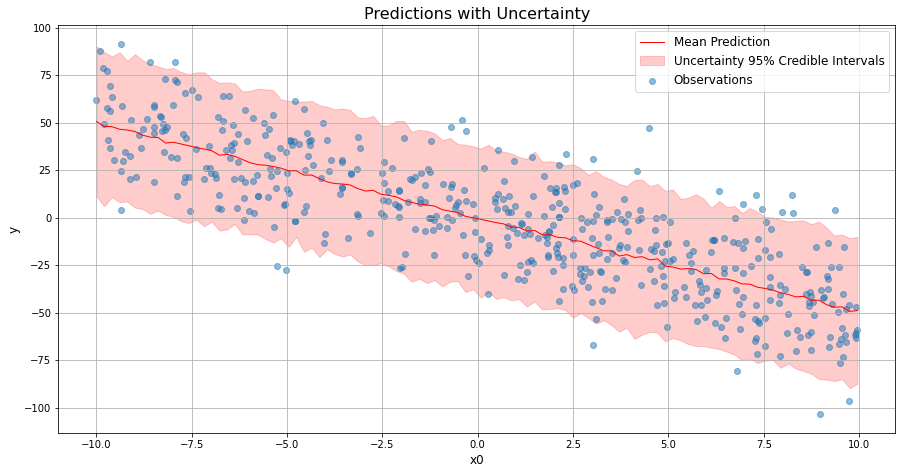

95.0 % of the target variables lie within the 95% credible interval.
52.6 % of the target variables lie within the 50% credible interval.


In [9]:

x0 = np.linspace(X_train[:,0].min(), X_train[:,0].max(), 100).reshape(-1,1)
x1 = np.linspace(X_train[:,1].min(), X_train[:,1].max(), 100).reshape(-1,1)
x = np.hstack([x0,x1])
n_functions = 1000
thinning = 100

ys =  ard.sample_from_posterior_predictive_distribution(x, n_functions, thinning)
y_mean = ys.mean(axis =1)

lower_bounds = np.percentile(ys, 2.5, axis=1)
upper_bounds = np.percentile(ys, 97.5, axis=1)

plt.figure(figsize=(15, 7.5))
plt.plot(x0, y_mean, label='Mean Prediction', color='red', linewidth = 1)  # Plot the mean prediction
plt.fill_between(x0.ravel(), lower_bounds, upper_bounds, color='red', alpha=0.2, label='Uncertainty 95% Credible Intervals') 
plt.scatter(X_train[:,0], y_train, alpha=0.5, label = "Observations")
plt.legend(fontsize = 12)
plt.title('Predictions with Uncertainty',fontsize = 16)
plt.xlabel('x0',fontsize = 12)
plt.ylabel('y',fontsize = 12)

plt.grid(True)
plt.savefig("figures\\simulated\\ard_prediction_with_uncertainty.png",  facecolor='white', transparent=False)
plt.show()

lower_bounds = np.percentile(ys, 2.5)
upper_bounds = np.percentile(ys, 97.5)


within_bounds = (y_train >= lower_bounds) & (y_train <= upper_bounds)
print(f"{within_bounds.mean()*100} % of the target variables lie within the 95% credible interval.")

lower_bounds = np.percentile(ys, 25)
upper_bounds = np.percentile(ys, 75)


within_bounds = (y_train >= lower_bounds) & (y_train <= upper_bounds)
print(f"{within_bounds.mean()*100} % of the target variables lie within the 50% credible interval.")

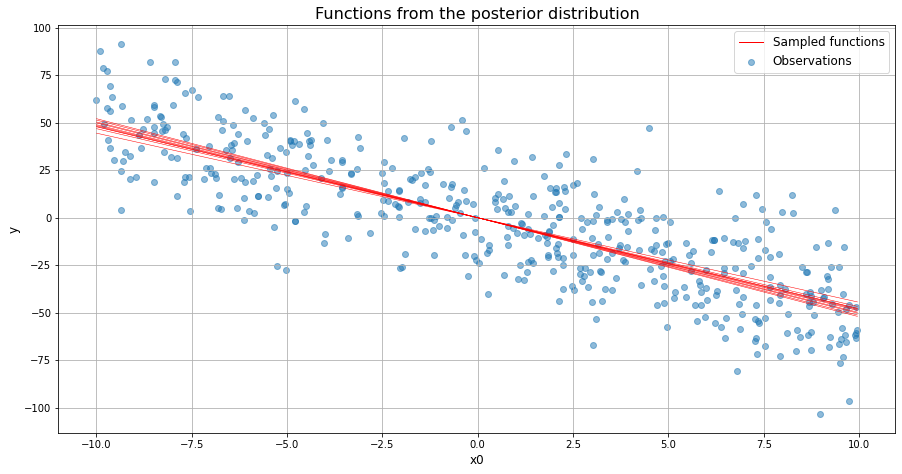

In [10]:
# Plot some functions from posterior to see whether things make sense

x0 = np.linspace(X_train[:,0].min(), X_train[:,0].max(), 100).reshape(-1,1)
x1 = np.linspace(X_train[:,1].min(), X_train[:,1].max(), 100).reshape(-1,1)
x = np.hstack([x0,x1])
n_functions = 100
thinning = 100


n_functions = 10
thinning = 10

plt.figure(figsize=(15, 7.5))
for i in range(n_functions):
    y_pred = x @ w_samples[int(burn_in + (i-1)*thinning), :]
    plt.plot(x0, y_pred.reshape(-1, 1), c='r',linewidth=0.5)
plt.plot([], [], c='r', label= "Sampled functions",linewidth=1)

plt.scatter(X_train[:,0], y_train, alpha=0.5, label = "Observations")
plt.legend(fontsize = 12)
plt.title('Functions from the posterior distribution',fontsize = 16)
plt.xlabel('x0',fontsize = 12)
plt.ylabel('y',fontsize = 12)

plt.grid(True)
plt.savefig("figures\\simulated\\ard_functions_from_posterior.png",  facecolor='white', transparent=False)
plt.show()



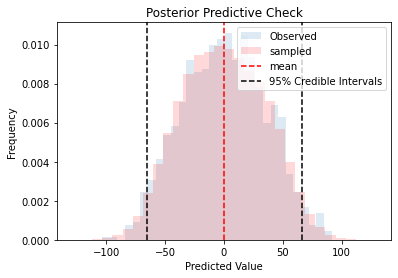

In [11]:
import matplotlib.pyplot as plt

ys = ard.sample_from_posterior_predictive_distribution(X,100,10)
ys = ys.ravel()
lower_bounds = np.percentile(ys, 2.5)
upper_bounds = np.percentile(ys, 97.5)
# Plotting the observed data and overlaying the simulated data distribution
plt.hist(y, bins=30, alpha=0.15, label='Observed', density=True )
plt.hist(ys, bins=30, alpha=0.15, color='red', label='sampled', density=True )
plt.axvline(ys.mean(), color='r', linestyle='--', label='mean')
plt.axvline(lower_bounds, color='black', linestyle='--', label='95% Credible Intervals')
plt.axvline(upper_bounds, color='black', linestyle='--')

plt.legend()
plt.title('Posterior Predictive Check')
plt.xlabel('Predicted Value') 
plt.ylabel('Frequency')
plt.show()

## Simulation study

- Do a small simulation study to verify whether the ARD priors can mitigate overffitting. 
- When does ARD work? When doesn't it work?
- Vary function $f$, number of dimensions $D$, number of samples $N$, the amount of noise $\sigma^2_{y|X}$ and most the importantly number of relevant features $D_{relevant}$
- Learn a "standard" and ARD Bayesian Linear regression and compare and visualize the results. Use appropriate measures to assess performance.
- Assess convergence of the Gibbs sampling.

In [12]:

sim_datasets = {"S1": {"n_samples": 50,      "n_features": 2,   "n_relevant":1,         "noise":20},
                "S2": {"n_samples": 50,      "n_features": 10,   "n_relevant":8,         "noise":5},
                "S3": {"n_samples": 100,      "n_features": 25,   "n_relevant":5,         "noise":10},
                "S4": {"n_samples": 200,    "n_features": 50,  "n_relevant":5,        "noise":25}}



In [13]:
np.random.seed(seed)





models = {"BLR": BayesianRegression(a0=0.1, b0=0.1,n_iter=n_iters, random_state=seed,beta=1,alpha=0.1), 
          "ARD": ARDRegression(a0=0.1, b0=0.1, c0=1, d0=0.01,n_iter=n_iters, random_state=seed,beta=1),
          "LR" : LinearRegression(fit_intercept=False),
          "Ridge" : Ridge(fit_intercept=False, alpha=0.1),
           "Lasso": Lasso(fit_intercept=False, alpha=0.1) }


sim_results = {"BLR": {k: {} for k in sim_datasets.keys()}, "ARD": {k: {} for k in sim_datasets.keys()},
                "LR" : {k: {} for k in sim_datasets.keys()},
                "Ridge" : {k: {} for k in sim_datasets.keys()},
                "Lasso": {k: {} for k in sim_datasets.keys()}}


training_info = {"BLR": {k: {} for k in sim_datasets.keys()}, "ARD": {k: {} for k in sim_datasets.keys()}}

coef_info =  {  "true" : {k: {} for k in sim_datasets.keys()},
                "BLR": {k: {} for k in sim_datasets.keys()},
                "ARD": {k: {} for k in sim_datasets.keys()},
                "LR" : {k: {} for k in sim_datasets.keys()},
                "Ridge" : {k: {} for k in sim_datasets.keys()},
                "Lasso": {k: {} for k in sim_datasets.keys()}}

predictive_distribution_info = {"BLR": {k: {} for k in sim_datasets.keys()}, "ARD": {k: {} for k in sim_datasets.keys()}}

for model_name, model in models.items():
    for i,(df_name, settings) in enumerate(sim_datasets.items()):
        print(f"Training '{model_name}' on {df_name}..." )
        X, y,_,coef = simulate_data(n_samples=2100, n_features=settings["n_features"], n_informative=settings["n_relevant"], noise=settings["noise"], coef=True, random_state=seed+i)
        X_train,X_val_test, y_train,y_val_test = train_test_split(X, y, train_size= settings["n_samples"], random_state=seed) # training data is of size N
        X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, train_size= 1000, random_state=seed)            # Validation data is of size 1000
        X_test = X_test[:1000,:];  y_test = y_test[:1000]                                                                     # test data is of size 1000
        
        coef_info["true"][df_name] = coef
        if model_name == "ARD":
            w_samples, beta_samples,alpha_samples, log_probs = model.fit(X_train,y_train,verbose=1000)
            training_info[model_name][df_name]["alpha_samples"]=alpha_samples
        elif model_name =="BLR":
            w_samples, beta_samples, log_probs = model.fit(X_train,y_train,verbose=1000)
        else:
            model.fit(X_train,y_train)
            
        if  model_name in ["BLR","ARD"]:   

            training_info[model_name][df_name]["log_probs"]=log_probs
            training_info[model_name][df_name]["w_samples"]=w_samples
            training_info[model_name][df_name]["beta_samples"]=beta_samples

            coef_info[model_name][df_name] = (w_samples.mean(axis=0), w_samples.std(axis=0))

            prediction_samples_train = model.sample_from_posterior_predictive_distribution(X_train, 1000, 10)

            # 95% credible interval
            lower_bounds_2_5 = np.percentile(prediction_samples_train, 2.5)
            upper_bounds_97_5 = np.percentile(prediction_samples_train, 97.5)

            # 50% credible interval
            lower_bounds_25 = np.percentile(prediction_samples_train, 25)
            upper_bounds_75 = np.percentile(prediction_samples_train, 75)


            within_bounds_95 = (y_train >= lower_bounds_2_5) & (y_train <= upper_bounds_97_5)
            within_bounds_50 = (y_train >= lower_bounds_25) & (y_train <= upper_bounds_75)

            predictive_distribution_info[model_name][df_name]["training within_bounds_95"] = within_bounds_95.mean()*100
            predictive_distribution_info[model_name][df_name]["training within_bounds_50"] = within_bounds_50.mean()*100


     
            


            prediction_samples_validation = model.sample_from_posterior_predictive_distribution(X_val,1000,10)

            # 95% credible interval
            lower_bounds_2_5 = np.percentile(prediction_samples_validation, 2.5)
            upper_bounds_97_5 = np.percentile(prediction_samples_validation, 97.5)

            # 50% credible interval
            lower_bounds_25 = np.percentile(prediction_samples_validation, 25)
            upper_bounds_75 = np.percentile(prediction_samples_validation, 75)


            within_bounds_95 = (y_val >= lower_bounds_2_5) & (y_val <= upper_bounds_97_5)
            within_bounds_50 = (y_val >= lower_bounds_25) & (y_val <= upper_bounds_75)

            predictive_distribution_info[model_name][df_name]["validation within_bounds_95"] = within_bounds_95.mean()*100
            predictive_distribution_info[model_name][df_name]["validation within_bounds_50"] = within_bounds_50.mean()*100


            training_info[model_name][df_name]["prediction_samples_train"] = prediction_samples_train
            training_info[model_name][df_name]["prediction_samples_validation"] = prediction_samples_validation
            
            predictive_distribution_info



            sim_results[model_name][df_name]["Training MSE"] = mean_squared_error(y_train, prediction_samples_train.mean(axis=1))
            sim_results[model_name][df_name]["Training SD"] = np.nan
            sim_results[model_name][df_name]["Validation MSE"] = mean_squared_error(y_val,prediction_samples_validation.mean(axis=1))
            sim_results[model_name][df_name]["Validation SD"] = np.nan


        else:
            sim_results[model_name][df_name]["Training MSE"] = mean_squared_error(y_train, model.predict(X_train))
            sim_results[model_name][df_name]["Training SD"] = np.nan
            sim_results[model_name][df_name]["Validation MSE"] = mean_squared_error(y_val, model.predict(X_val))
            sim_results[model_name][df_name]["Validation SD"] = np.nan

            coef_info[model_name][df_name] = model.coef_
    
        print()


Training 'BLR' on S1...
Iteration 0 - unnormalized_log_posterior: -221.60
Iteration 1000 - unnormalized_log_posterior: -222.21
Iteration 2000 - unnormalized_log_posterior: -221.91
Iteration 3000 - unnormalized_log_posterior: -222.24
Iteration 4000 - unnormalized_log_posterior: -223.12
Iteration 5000 - unnormalized_log_posterior: -221.78
Iteration 6000 - unnormalized_log_posterior: -223.67
Iteration 7000 - unnormalized_log_posterior: -223.14
Iteration 8000 - unnormalized_log_posterior: -222.95
Iteration 9000 - unnormalized_log_posterior: -222.04

Training 'BLR' on S2...
Iteration 0 - unnormalized_log_posterior: -249.94
Iteration 1000 - unnormalized_log_posterior: -218.77
Iteration 2000 - unnormalized_log_posterior: -220.78
Iteration 3000 - unnormalized_log_posterior: -219.38
Iteration 4000 - unnormalized_log_posterior: -219.24
Iteration 5000 - unnormalized_log_posterior: -221.96
Iteration 6000 - unnormalized_log_posterior: -218.50
Iteration 7000 - unnormalized_log_posterior: -220.89
Ite

In [14]:
import pandas as pd
df = pd.DataFrame({(outerKey, innerKey): values
                   for outerKey, innerDict in sim_results.items()
                   for innerKey, values in innerDict.items()})

df = df.T  # Transpose to have models as rows
df.reset_index(inplace=True)
df
df.columns = ['Model', 'Dataset', 'Training', 'Training SD', 'Validation', 'Validation SD']


df['Training'] = round(df['Training'],2) 
df['Validation'] = round(df['Validation'],2) 

# df['Training MSE (SD)'] = df['Training MSE'].astype(str) + " (" + round(df['Training SD'],2).astype(str) + ")"

# # Combine 'Validation MSE' and 'Validation SD'
# df['Validation MSE (SD)'] =df['Validation MSE'].astype(str) + " (" + round(df['Validation SD'],2).astype(str) + ")"



# Drop the old columns
df.drop(['Training SD', 'Validation SD'], axis=1, inplace=True)

df = df.sort_values(["Dataset", "Model"])
# print(df.to_latex(index=False))

pivot_df = df.pivot(index='Model', columns='Dataset')

pivot_df.columns = [f'{col[1]} {col[0]}' for col in pivot_df.columns]
desired_column_order = [
    'S1 Training', 'S1 Validation',
    'S2 Training', 'S2 Validation',
    'S3 Training', 'S3 Validation',
    'S4 Training', 'S4 Validation'
]
sorted_pivot_df = pivot_df.reindex(columns=desired_column_order)
colnames = [tuple(col.split(" ") ) for col in sorted_pivot_df.columns]
columns = pd.MultiIndex.from_tuples(colnames)


sorted_pivot_df.columns = pd.MultiIndex.from_tuples(colnames)
sorted_pivot_df
print(sorted_pivot_df.to_latex(index=True, multicolumn_format = "c", position = "c", multirow=True))

\begin{table}[c]
\centering
\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{c}{S1} & \multicolumn{2}{c}{S2} & \multicolumn{2}{c}{S3} & \multicolumn{2}{c}{S4} \\
{} & Training & Validation & Training & Validation & Training & Validation & Training & Validation \\
Model &          &            &          &            &          &            &          &            \\
\midrule
ARD   &   383.59 &     405.14 &    17.12 &      30.03 &    73.90 &     112.49 &   537.37 &     635.50 \\
BLR   &   372.64 &     416.88 &    17.12 &      32.51 &    66.38 &     127.70 &   444.72 &     782.93 \\
LR    &   372.90 &     412.64 &    16.85 &      31.12 &    66.22 &     127.58 &   444.51 &     777.80 \\
Lasso &   372.90 &     412.59 &    16.85 &      31.20 &    66.23 &     127.00 &   444.53 &     774.67 \\
Ridge &   372.90 &     412.65 &    16.85 &      31.18 &    66.22 &     127.58 &   444.51 &     777.79 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\mb-92\AppData\Local\Temp\ipykernel_32276\585994884.py:44: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sorted_pivot_df.to_latex(index=True, multicolumn_format = "c", position = "c", multirow=True))


In [15]:
df = pd.DataFrame({(outerKey, innerKey): values
                   for outerKey, innerDict in predictive_distribution_info.items()
                   for innerKey, values in innerDict.items()})
df = df.T  # Transpose to have models as rows
df.reset_index(inplace=True)
df.columns = ['Model', 'Dataset', 'Training95', 'Training50', 'Validation95', 'Validation50']
df
pivot_df = df.pivot(index='Model', columns='Dataset')


pivot_df.columns = [f'{col[1]} {col[0]}' for col in pivot_df.columns]
pivot_df
desired_column_order = [
    'S1 Training50','S1 Training95', 'S1 Validation50','S1 Validation95', 
    'S2 Training50','S2 Training95', 'S2 Validation50','S2 Validation95',
    'S3 Training50','S3 Training95', 'S3 Validation50','S3 Validation95',
    'S4 Training50','S4 Training95', 'S4 Validation50','S4 Validation95',
]
sorted_pivot_df = pivot_df.reindex(columns=desired_column_order)
colnames = [tuple(col.split(" ") ) for col in sorted_pivot_df.columns]
print(colnames)
columns = pd.MultiIndex.from_tuples(colnames)


sorted_pivot_df.columns = pd.MultiIndex.from_tuples(colnames)
sorted_pivot_df
colnames = [col for col in sorted_pivot_df.columns if  "Training" in col[1]]
print(sorted_pivot_df[colnames].to_latex(index=True, multicolumn_format = "c", position = "c", multirow=True))

colnames = [col for col in sorted_pivot_df.columns if  "Validation" in col[1]]
print(sorted_pivot_df[colnames].to_latex(index=True, multicolumn_format = "c", position = "c", multirow=True))


[('S1', 'Training50'), ('S1', 'Training95'), ('S1', 'Validation50'), ('S1', 'Validation95'), ('S2', 'Training50'), ('S2', 'Training95'), ('S2', 'Validation50'), ('S2', 'Validation95'), ('S3', 'Training50'), ('S3', 'Training95'), ('S3', 'Validation50'), ('S3', 'Validation95'), ('S4', 'Training50'), ('S4', 'Training95'), ('S4', 'Validation50'), ('S4', 'Validation95')]
\begin{table}[c]
\centering
\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{2}{c}{S1} & \multicolumn{2}{c}{S2} & \multicolumn{2}{c}{S3} & \multicolumn{2}{c}{S4} \\
{} & Training50 & Training95 & Training50 & Training95 & Training50 & Training95 & Training50 & Training95 \\
Model &            &            &            &            &            &            &            &            \\
\midrule
ARD   &       50.0 &       96.0 &       50.0 &       94.0 &       53.0 &       95.0 &       51.5 &       96.0 \\
BLR   &       52.0 &       96.0 &       50.0 &       94.0 &       53.0 &       95.0 &       51.0 &       96.0 \\
\bo

C:\Users\mb-92\AppData\Local\Temp\ipykernel_32276\4071719704.py:28: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sorted_pivot_df[colnames].to_latex(index=True, multicolumn_format = "c", position = "c", multirow=True))
C:\Users\mb-92\AppData\Local\Temp\ipykernel_32276\4071719704.py:31: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(sorted_pivot_df[colnames].to_latex(index=True, multicolumn_format = "c", position = "c", multirow=True))


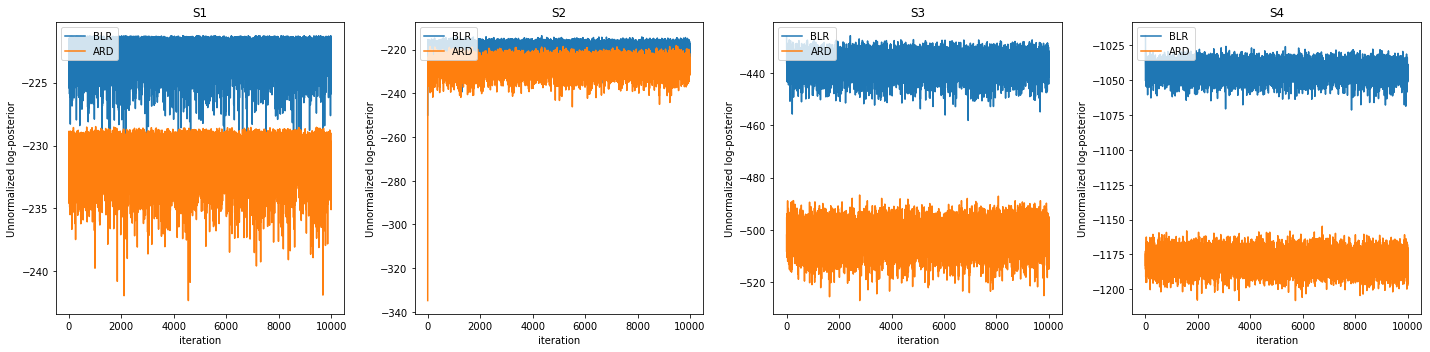

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize = (20,5))
i = 0

for df_name in ["S"+ str(i )  for i in range(1,5)]:
    for model_name in ['BLR',"ARD"]:
        info  = training_info[model_name][df_name]
        axs[i].plot(info["log_probs"], label = model_name)
    axs[i].legend(loc = "upper left")
    axs[i].set_title(df_name)
    axs[i].set_xlabel("iteration")
    axs[i].set_ylabel("Unnormalized log-posterior")
    i+=1

plt.tight_layout()
plt.savefig("figures\\simulated\\simulated_convergence_and_mixing_logprob.png",  facecolor='white', transparent=False)
plt.show()           

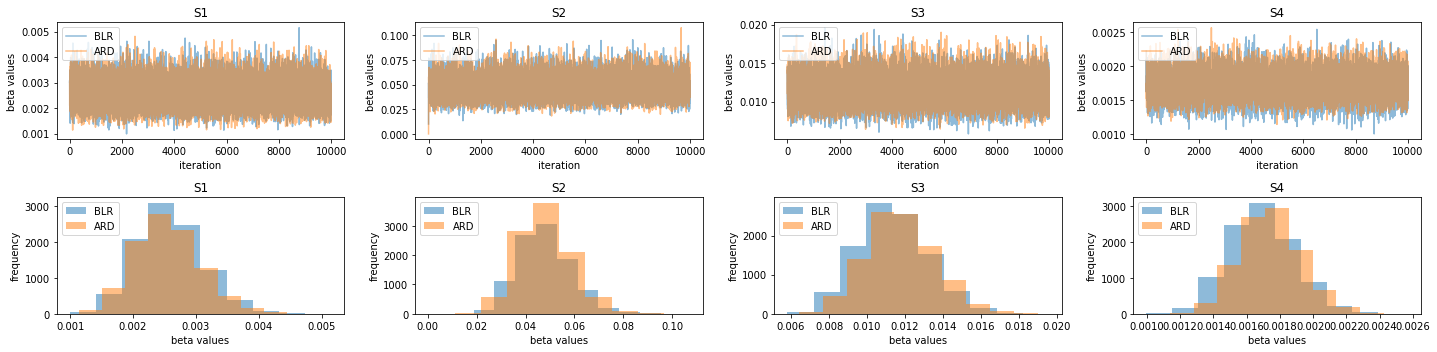

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (20,5))
i = 0

for df_name in ["S"+ str(i )  for i in range(1,5)]:
    for model_name in ['BLR',"ARD"]:
        info  = training_info[model_name][df_name]
        axs[0,i].plot(info["beta_samples"], label = model_name, alpha = 0.5)
        axs[1,i].hist(info["beta_samples"], label = model_name, alpha = 0.5)
    
    axs[0,i].legend(loc = "upper left")
    axs[0,i].set_title(df_name)
    axs[0,i].set_xlabel("iteration")
    axs[0,i].set_ylabel("beta values")

    axs[1,i].legend(loc = "upper left")
    axs[1,i].set_title(df_name)
    axs[1,i].set_xlabel("beta values")
    axs[1,i].set_ylabel("frequency")

    i+=1
plt.tight_layout()
plt.savefig("figures\\simulated\\simulated_convergence_and_mixing_beta.png",  facecolor='white', transparent=False)
plt.show()     

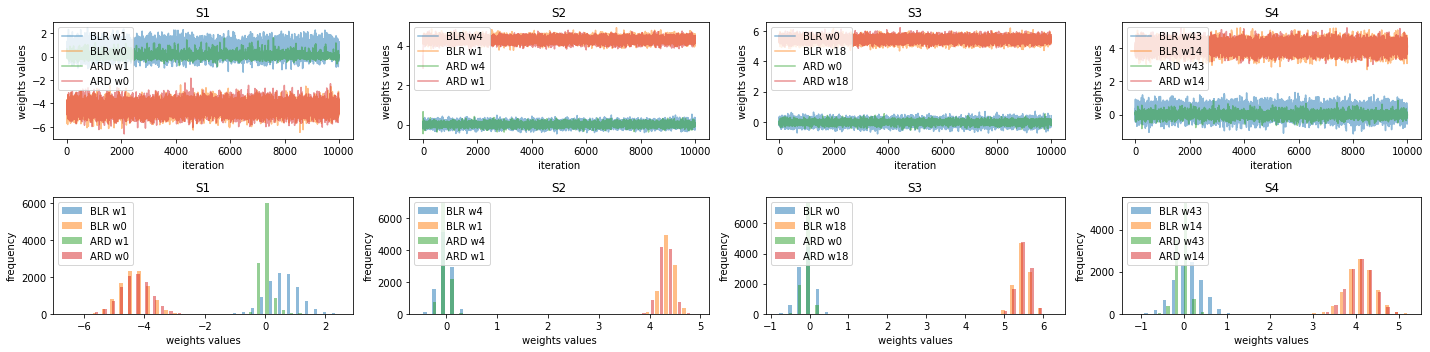

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize = (20,5))
i = 0

for df_name in ["S"+ str(i )  for i in range(1,5)]:
    for model_name in ['BLR',"ARD"]:
        np.random.seed(seed)
        info  = training_info[model_name][df_name]
        w_samples = info["w_samples"]
        ind = []
        non_zero =  ((np.abs(w_samples.mean(axis=0)) > 1 ).astype(int) + (np.abs(w_samples.mean(axis=0)) <6).astype(int)) >1
        zero = np.abs(w_samples.mean(axis=0)) < 1 
        ind.append(np.random.choice( np.arange(w_samples.shape[1])[zero], size= 1, replace=False)[0])
        ind.append(np.random.choice(np.arange(w_samples.shape[1])[non_zero], size= 1, replace=False)[0])
        axs[0,i].plot(info["w_samples"][:,ind], label = [model_name + f" w{w_ind}" for w_ind in ind], alpha = 0.5)
        axs[1,i].hist(info["w_samples"][:,ind], label = [model_name + f" w{w_ind}" for w_ind in ind], alpha = 0.5, bins = 30)

    axs[0,i].legend(loc = "upper left")
    axs[0,i].set_title(df_name)
    axs[0,i].set_xlabel("iteration")
    axs[0,i].set_ylabel("weights values")

    axs[1,i].legend(loc = "upper left")
    axs[1,i].set_title(df_name)
    axs[1,i].set_xlabel("weights values")
    axs[1,i].set_ylabel("frequency")
    i+=1

plt.tight_layout()
plt.savefig("figures\\simulated\\simulated_convergence_and_mixing_weights.png",  facecolor='white', transparent=False)
plt.show() 

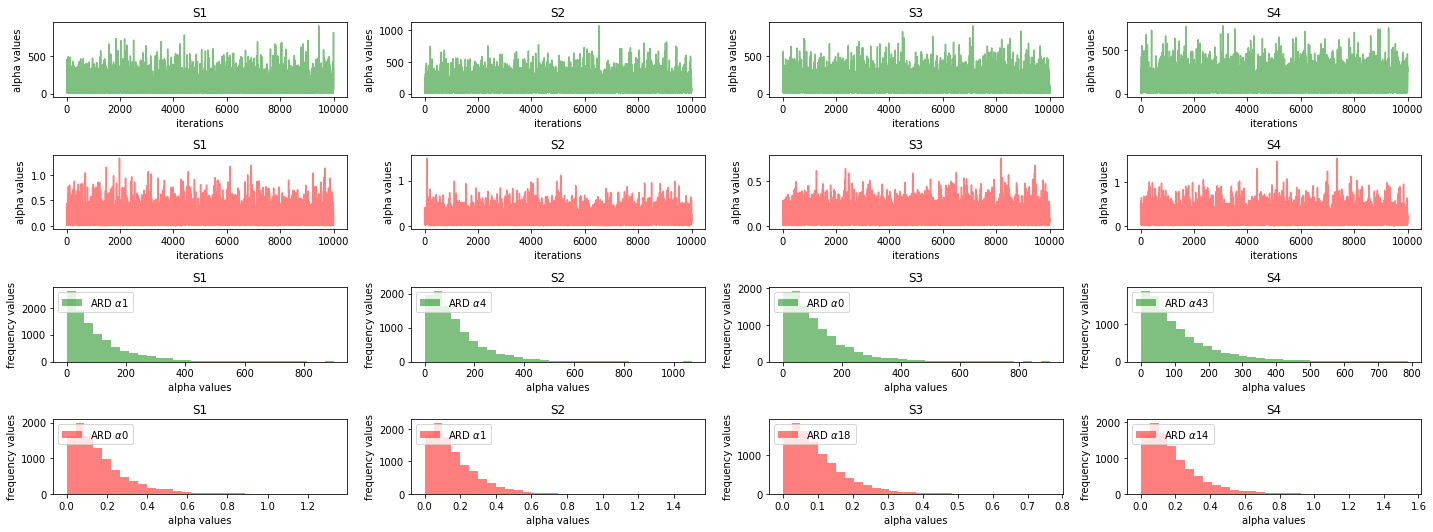

In [19]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize = (20,7.5))
i = 0
col = ["green","r"]
bins = [30, 30]
for df_name in ["S"+ str(i )  for i in range(1,5)]:
    for model_name in ["ARD"]:
        np.random.seed(seed)
        info  = training_info[model_name][df_name]
        alpha_samples = info["alpha_samples"]
        w_samples = info["w_samples"]
        ind = []
        non_zero =  ((np.abs(w_samples.mean(axis=0)) > 1 ).astype(int) + (np.abs(w_samples.mean(axis=0)) <6).astype(int)) >1
        zero = np.abs(w_samples.mean(axis=0)) < 1 
        ind.append(np.random.choice( np.arange(w_samples.shape[1])[zero], size= 1, replace=False)[0])
        ind.append(np.random.choice(np.arange(w_samples.shape[1])[non_zero], size= 1, replace=False)[0])
        for j in range(2):
            axs[j+2,i].hist(alpha_samples[:,ind[j]], label = model_name + r" $\alpha" + f"{ind[j]}" +r"$", color = col[j] ,alpha = 0.5, bins = bins[j])
            axs[j+2,i].legend(loc = "upper left")

            axs[j+2,i].set_title(df_name)
            axs[j+2,i].set_xlabel("alpha values")
            axs[j+2,i].set_ylabel("frequency values")
            axs[j,i].plot(alpha_samples[:,ind[j]], label = model_name + r" $\alpha" + f"{ind[j]}" +r"$", color = col[j] ,alpha = 0.5)
            axs[j,i].set_title(df_name)
            axs[j,i].set_xlabel("iterations")
            axs[j,i].set_ylabel("alpha values")

            
    i+=1

plt.tight_layout()
plt.savefig("figures\\simulated\\simulated_convergence_and_mixing_alpha.png",  facecolor='white', transparent=False)
plt.show() 

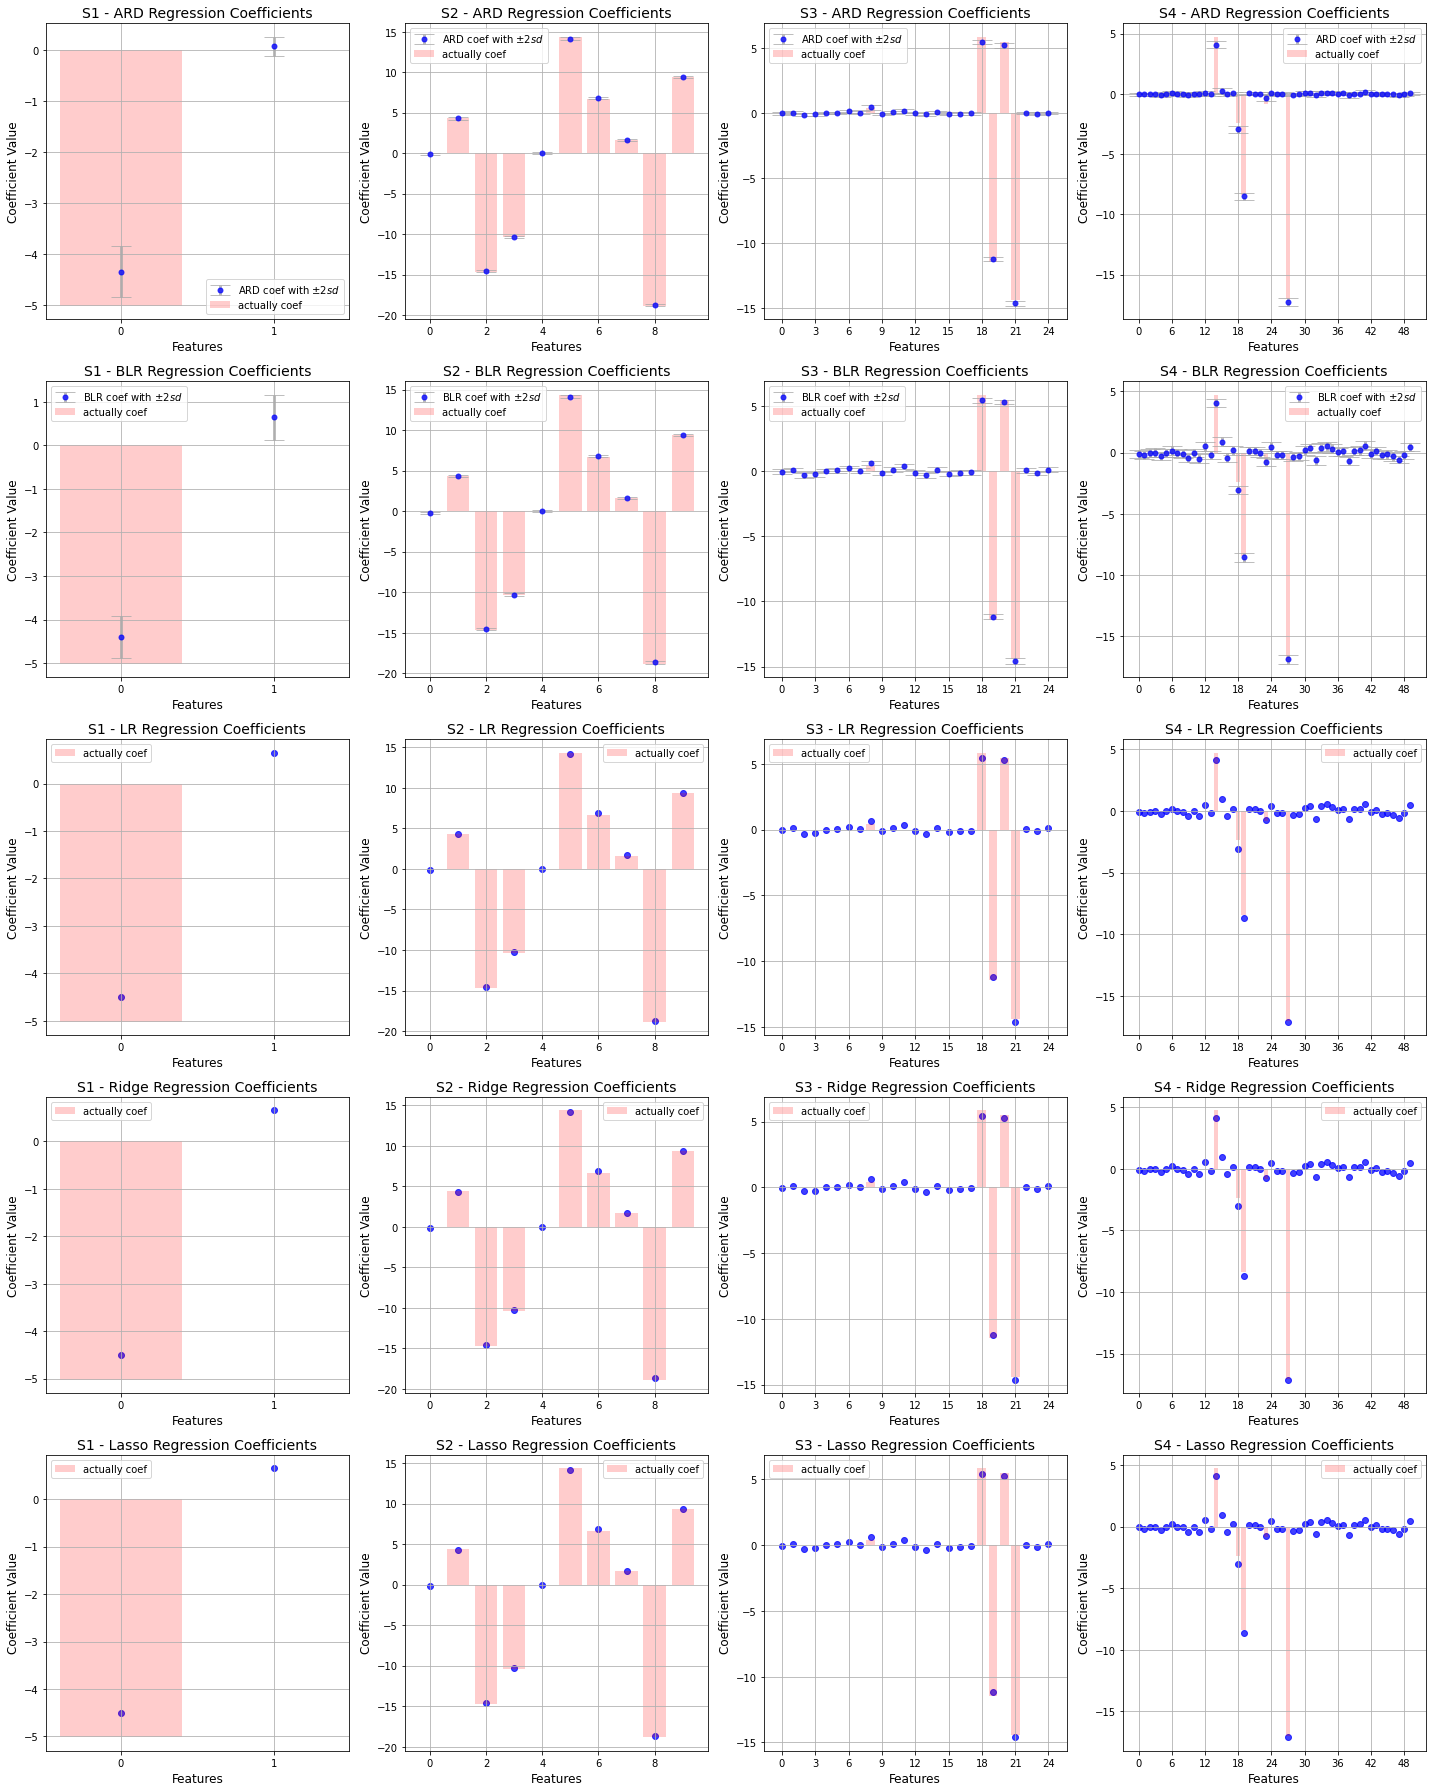

In [20]:
fig, ax = plt.subplots(figsize=(20, 25), ncols=4, nrows=5)
i = 0
from matplotlib.ticker import MaxNLocator


for df_name in ["S"+ str(i )  for i in range(1,5)]:
    coef  = coef_info["true"][df_name]
    j = 0
    for model_name in ["ARD","BLR", "LR","Ridge", "Lasso"]:

        if model_name in ["ARD","BLR"]:
            w_MAP,w_std  = coef_info[model_name][df_name]
            errors = w_std
            
            ax[j,i].errorbar(range(len(w_MAP)), w_MAP, yerr=errors, fmt="o",color='b', label=f"{model_name}" +r' coef with $\pm 2sd$',ecolor='darkgray',markersize = 5,  elinewidth=3, capsize=10, alpha = 0.75)
        else: 
            w_MAP = coef_info[model_name][df_name]
            ax[j,i].scatter(range(len(w_MAP)), w_MAP,color='b', alpha = 0.75)
        ax[j,i].bar(range(len(coef)), coef, alpha = 0.2, color='r', label='actually coef')
    

        ax[j,i].set_title(f'{df_name} - {model_name} Regression Coefficients',fontsize=14)
        ax[j,i].set_xlabel('Features',fontsize=12)
        ax[j,i].set_ylabel('Coefficient Value',fontsize=12)
        ax[j,i].legend()
        ax[j,i].xaxis.set_major_locator(MaxNLocator(integer=True))
        ax[j,i].grid(True)
        j +=1
    i+=1
plt.savefig("figures\\simulated\\simulated_parameter_analysis.png",  facecolor='white', transparent=False)
plt.tight_layout()
plt.show()
        


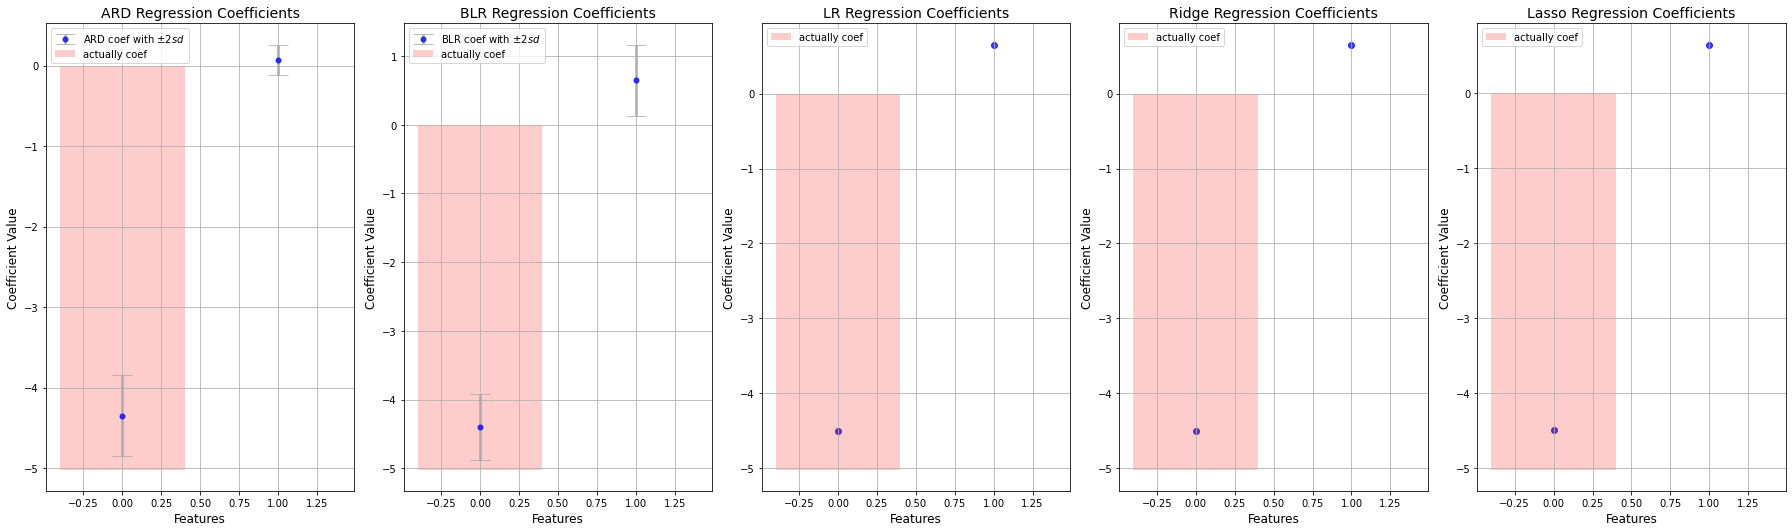

In [21]:
fig, ax = plt.subplots(figsize=(25, 7.5), ncols=5, nrows=1)
i = 0

for df_name in ["S"+ str(i )  for i in range(1,2)]:
    coef  = coef_info["true"][df_name]
    j = 0
    for model_name in ["ARD","BLR", "LR","Ridge", "Lasso"]:

        if model_name in ["ARD","BLR"]:
            w_MAP,w_std  = coef_info[model_name][df_name]
            errors = w_std
            
            ax[j].errorbar(range(len(w_MAP)), w_MAP, yerr=errors, fmt="o",color='b', label=f"{model_name}" +r' coef with $\pm 2sd$',ecolor='darkgray',markersize = 5,  elinewidth=3, capsize=10, alpha = 0.75)
        else: 
            w_MAP = coef_info[model_name][df_name]
            ax[j].scatter(range(len(w_MAP)), w_MAP,color='b', alpha = 0.75)
        ax[j].bar(range(len(coef)), coef, alpha = 0.2, color='r', label='actually coef')
    

        ax[j].set_title(f'{model_name} Regression Coefficients',fontsize=14)
        ax[j].set_xlabel('Features',fontsize=12)
        ax[j].set_ylabel('Coefficient Value',fontsize=12)
        ax[j].legend()
        ax[j].grid(True)
        j +=1
    i+=1

plt.tight_layout()
plt.show()

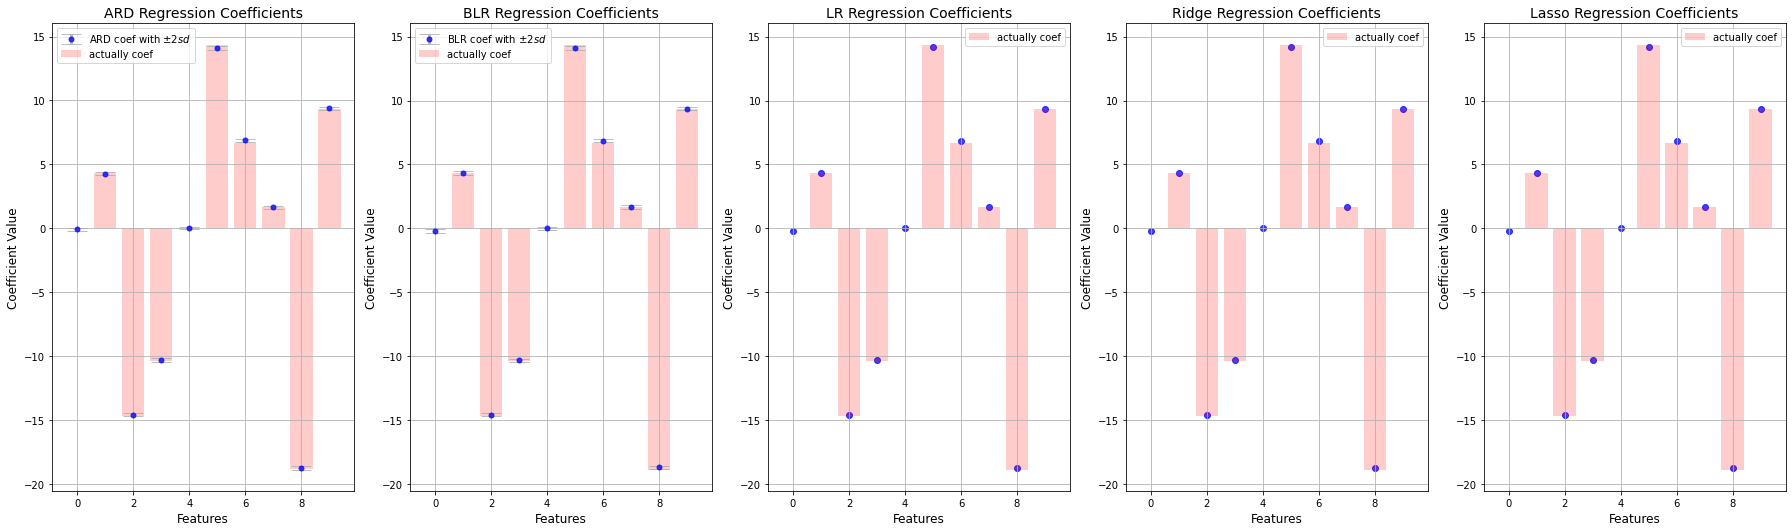

In [22]:
fig, ax = plt.subplots(figsize=(25, 7.5), ncols=5, nrows=1)
i = 0

for df_name in ["S"+ str(i )  for i in range(2,3)]:
    coef  = coef_info["true"][df_name]
    j = 0
    for model_name in ["ARD","BLR", "LR","Ridge", "Lasso"]:

        if model_name in ["ARD","BLR"]:
            w_MAP,w_std  = coef_info[model_name][df_name]
            errors = w_std
            
            ax[j].errorbar(range(len(w_MAP)), w_MAP, yerr=errors, fmt="o",color='b', label=f"{model_name}" +r' coef with $\pm 2sd$',ecolor='darkgray',markersize = 5,  elinewidth=3, capsize=10, alpha = 0.75)
        else: 
            w_MAP = coef_info[model_name][df_name]
            ax[j].scatter(range(len(w_MAP)), w_MAP,color='b', alpha = 0.75)
        ax[j].bar(range(len(coef)), coef, alpha = 0.2, color='r', label='actually coef')
    

        ax[j].set_title(f'{model_name} Regression Coefficients',fontsize=14)
        ax[j].set_xlabel('Features',fontsize=12)
        ax[j].set_ylabel('Coefficient Value',fontsize=12)
        ax[j].legend()
        ax[j].grid(True)
        j +=1
    i+=1

plt.tight_layout()
plt.show()

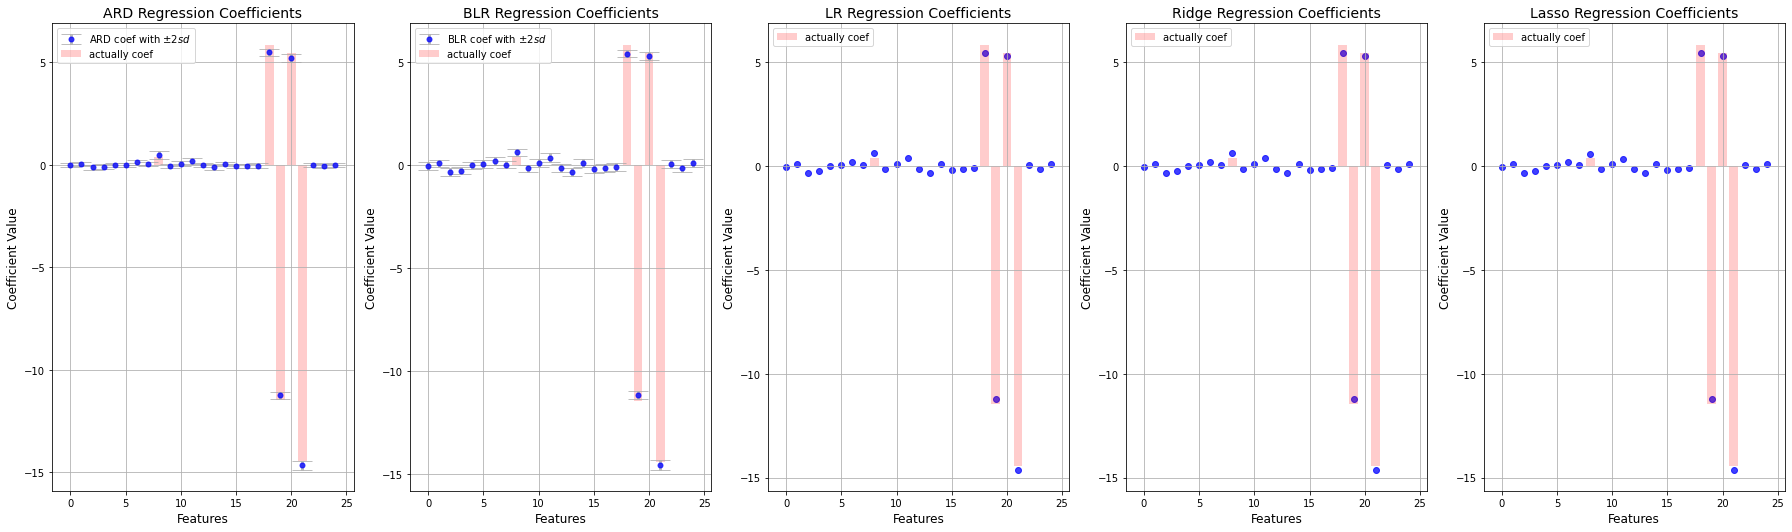

In [23]:
fig, ax = plt.subplots(figsize=(25, 7.5), ncols=5, nrows=1)
i = 0

for df_name in ["S"+ str(i )  for i in range(3,4)]:
    coef  = coef_info["true"][df_name]
    j = 0
    for model_name in ["ARD","BLR", "LR","Ridge", "Lasso"]:

        if model_name in ["ARD","BLR"]:
            w_MAP,w_std  = coef_info[model_name][df_name]
            errors = w_std
            
            ax[j].errorbar(range(len(w_MAP)), w_MAP, yerr=errors, fmt="o",color='b', label=f"{model_name}" +r' coef with $\pm 2sd$',ecolor='darkgray',markersize = 5,  elinewidth=3, capsize=10, alpha = 0.75)
        else: 
            w_MAP = coef_info[model_name][df_name]
            ax[j].scatter(range(len(w_MAP)), w_MAP,color='b', alpha = 0.75)
        ax[j].bar(range(len(coef)), coef, alpha = 0.2, color='r', label='actually coef')
    

        ax[j].set_title(f'{model_name} Regression Coefficients',fontsize=14)
        ax[j].set_xlabel('Features',fontsize=12)
        ax[j].set_ylabel('Coefficient Value',fontsize=12)
        ax[j].legend()
        ax[j].grid(True)
        j +=1
    i+=1

plt.tight_layout()
plt.show()

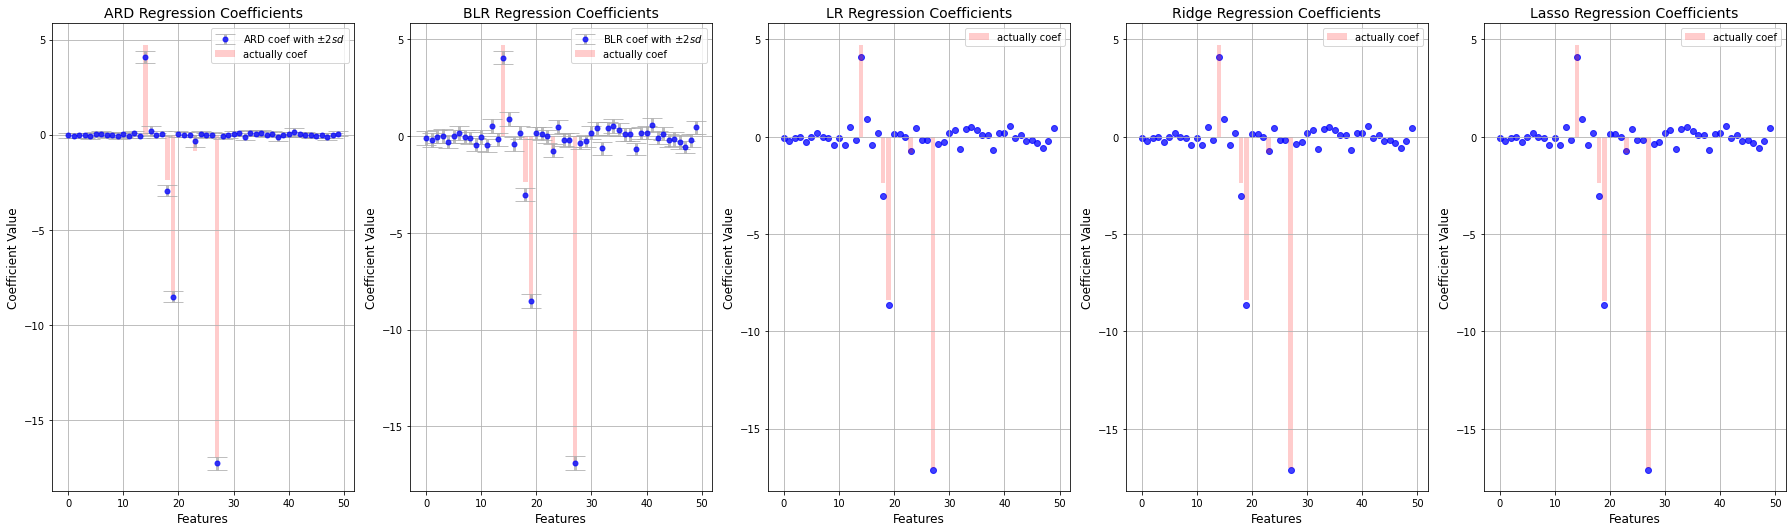

In [24]:
fig, ax = plt.subplots(figsize=(25, 7.5), ncols=5, nrows=1)
i = 0

for df_name in ["S"+ str(i )  for i in range(4,5)]:
    coef  = coef_info["true"][df_name]
    j = 0
    for model_name in ["ARD","BLR", "LR","Ridge", "Lasso"]:

        if model_name in ["ARD","BLR"]:
            w_MAP,w_std  = coef_info[model_name][df_name]
            errors = w_std
            
            ax[j].errorbar(range(len(w_MAP)), w_MAP, yerr=errors, fmt="o",color='b', label=f"{model_name}" +r' coef with $\pm 2sd$',ecolor='darkgray',markersize = 5,  elinewidth=3, capsize=10, alpha = 0.75)
        else: 
            w_MAP = coef_info[model_name][df_name]
            ax[j].scatter(range(len(w_MAP)), w_MAP,color='b', alpha = 0.75)
        ax[j].bar(range(len(coef)), coef, alpha = 0.2, color='r', label='actually coef')
    

        ax[j].set_title(f'{model_name} Regression Coefficients',fontsize=14)
        ax[j].set_xlabel('Features',fontsize=12)
        ax[j].set_ylabel('Coefficient Value',fontsize=12)
        ax[j].legend()
        ax[j].grid(True)
        j +=1
    i+=1

plt.tight_layout()
plt.show()

## Real Data study

- Load the data set *Lung_cancer_small.csv*. 
- Learn the linear regression model using this data. Assess convergence and
mixing. Do your results make sense? What variables affect the survival time
most?

In [25]:
import pandas as pd 
df_name = "Lung_cancer_small"
df = pd.read_csv(f"{df_name}.csv")
y = df.y.to_numpy()
X = df.drop(["y","delta"] , axis=1).to_numpy()

In [26]:
np.random.seed(seed)
from sklearn.model_selection import KFold


models = {
    "BLR": BayesianRegression(a0=0.1, b0=0.1,n_iter=n_iters, random_state=seed,beta=1,alpha=0.1,fit_intercept=True), 
          "ARD": ARDRegression(a0=0.1, b0=0.1, c0=0.1, d0=0.01,n_iter=n_iters, random_state=seed,beta=1,fit_intercept=True),
          "LR" : LinearRegression(fit_intercept=True),
          "Ridge" : Ridge(fit_intercept=True, alpha=0.1, max_iter=n_iters, tol=0.01),
           "Lasso": Lasso(fit_intercept=True, alpha=0.1, max_iter=n_iters, tol=0.01) }


results = {"BLR": {df_name:{"Training MSE":[],"Validation MSE":[]   }},
            "ARD": {df_name:{"Training MSE":[],"Validation MSE":[]   }},
                "LR" : {df_name:{"Training MSE":[],"Validation MSE":[]   }},
                "Ridge" : {df_name:{"Training MSE":[],"Validation MSE":[] }},
                "Lasso": {df_name:{"Training MSE":[],"Validation MSE":[]   }}
                }


training_info = {"BLR": {df_name:{}}, "ARD": {df_name:{}}}

coef_info =  { "BLR": {df_name:{}}, "ARD": {df_name:{}},
                "LR" : {df_name: {} },
                "Ridge" : {df_name: {} },
                "Lasso": {df_name: {} }}

predictive_distribution_info = {"BLR": {df_name:{}}, "ARD": {df_name:{}}}

for model_name, model in models.items():

    print(f"Training '{model_name}' on {df_name}..." )
    X_train_val,X_test, y_train_val,y_test = train_test_split(X, y, train_size= 0.8, random_state=seed)

    kf = KFold(n_splits=5,random_state=seed, shuffle=True)

    for i, (train_index, val_index) in enumerate(kf.split(X_train_val)):
        X_train = X_train_val[train_index,:]; y_train = y_train_val[train_index]
        X_val = X_train_val[val_index,:]; y_val = y_train_val[val_index]

        if model_name == "ARD":
            w_samples, beta_samples,alpha_samples, log_probs = model.fit(X_train,y_train,verbose=1000)
            training_info[model_name][df_name]["alpha_samples"]=alpha_samples
        elif model_name =="BLR":
            w_samples, beta_samples, log_probs = model.fit(X_train,y_train,verbose=1000)
        else:
            model.fit(X_train,y_train)
            
        if  model_name in ["BLR","ARD"]:   

            training_info[model_name][df_name]["log_probs"]=log_probs
            training_info[model_name][df_name]["w_samples"]=w_samples
            training_info[model_name][df_name]["beta_samples"]=beta_samples

            coef_info[model_name][df_name] = (w_samples.mean(axis=0), w_samples.std(axis=0))

            prediction_samples_train = model.sample_from_posterior_predictive_distribution( X_train, 1000, 1)

            # 95% credible interval
            lower_bounds_2_5 = np.percentile(prediction_samples_train, 2.5)
            upper_bounds_97_5 = np.percentile(prediction_samples_train, 97.5)

            # 50% credible interval
            lower_bounds_25 = np.percentile(prediction_samples_train, 25)
            upper_bounds_75 = np.percentile(prediction_samples_train, 75)


            within_bounds_95 = (y_train >= lower_bounds_2_5) & (y_train <= upper_bounds_97_5)
            within_bounds_50 = (y_train >= lower_bounds_25) & (y_train <= upper_bounds_75)

            predictive_distribution_info[model_name][df_name]["training within_bounds_95"] = within_bounds_95.mean()*100
            predictive_distribution_info[model_name][df_name]["training within_bounds_50"] = within_bounds_50.mean()*100


        


            prediction_samples_validation = model.sample_from_posterior_predictive_distribution(X_val,1000,1)

            # 95% credible interval
            lower_bounds_2_5 = np.percentile(prediction_samples_validation, 2.5)
            upper_bounds_97_5 = np.percentile(prediction_samples_validation, 97.5)

            # 50% credible interval
            lower_bounds_25 = np.percentile(prediction_samples_validation, 25)
            upper_bounds_75 = np.percentile(prediction_samples_validation, 75)


            within_bounds_95 = (y_val >= lower_bounds_2_5) & (y_val <= upper_bounds_97_5)
            within_bounds_50 = (y_val >= lower_bounds_25) & (y_val <= upper_bounds_75)

            predictive_distribution_info[model_name][df_name]["validation within_bounds_95"] = within_bounds_95.mean()*100
            predictive_distribution_info[model_name][df_name]["validation within_bounds_50"] = within_bounds_50.mean()*100


            # training_info[model_name][df_name]["prediction_samples_train"] = prediction_samples_train
            # training_info[model_name][df_name]["prediction_samples_validation"] = prediction_samples_validation
            
            predictive_distribution_info



            results[model_name][df_name]["Training MSE"].append(mean_squared_error(y_train, prediction_samples_train.mean(axis=1)))

            results[model_name][df_name]["Validation MSE"].append(mean_squared_error(y_val,prediction_samples_validation.mean(axis=1)))



        else:
            results[model_name][df_name]["Training MSE"].append(mean_squared_error(y_train, model.predict(X_train)))

            results[model_name][df_name]["Validation MSE"].append(mean_squared_error(y_val, model.predict(X_val)))


            coef_info[model_name][df_name] = model.coef_

        print()


Training 'BLR' on Lung_cancer_small...
Iteration 0 - unnormalized_log_posterior: -323.87
Iteration 50 - unnormalized_log_posterior: -247.03
Iteration 100 - unnormalized_log_posterior: -290.26
Iteration 150 - unnormalized_log_posterior: -337.44
Iteration 200 - unnormalized_log_posterior: -359.62
Iteration 250 - unnormalized_log_posterior: -329.29
Iteration 300 - unnormalized_log_posterior: -271.03
Iteration 350 - unnormalized_log_posterior: -326.15
Iteration 400 - unnormalized_log_posterior: -236.22
Iteration 450 - unnormalized_log_posterior: -223.76
Iteration 500 - unnormalized_log_posterior: -256.78
Iteration 550 - unnormalized_log_posterior: -304.70
Iteration 600 - unnormalized_log_posterior: -205.81
Iteration 650 - unnormalized_log_posterior: -272.62
Iteration 700 - unnormalized_log_posterior: -276.52
Iteration 750 - unnormalized_log_posterior: -263.25
Iteration 800 - unnormalized_log_posterior: -333.56
Iteration 850 - unnormalized_log_posterior: -347.57
Iteration 900 - unnormalized

c:\Users\mb-92\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_multivariate.py:657: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


Iteration 7500 - unnormalized_log_posterior: -238.85
Iteration 7550 - unnormalized_log_posterior: -244.75
Iteration 7600 - unnormalized_log_posterior: -257.14
Iteration 7650 - unnormalized_log_posterior: -247.74
Iteration 7700 - unnormalized_log_posterior: -323.98
Iteration 7750 - unnormalized_log_posterior: -247.31
Iteration 7800 - unnormalized_log_posterior: -234.00
Iteration 7850 - unnormalized_log_posterior: -263.88
Iteration 7900 - unnormalized_log_posterior: -286.12
Iteration 7950 - unnormalized_log_posterior: -351.84
Iteration 8000 - unnormalized_log_posterior: -233.55
Iteration 8050 - unnormalized_log_posterior: -278.68
Iteration 8100 - unnormalized_log_posterior: -258.49
Iteration 8150 - unnormalized_log_posterior: -286.45
Iteration 8200 - unnormalized_log_posterior: -265.74
Iteration 8250 - unnormalized_log_posterior: -328.97
Iteration 8300 - unnormalized_log_posterior: -281.93
Iteration 8350 - unnormalized_log_posterior: -336.59
Iteration 8400 - unnormalized_log_posterior: -

c:\Users\mb-92\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_multivariate.py:657: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


Iteration 1550 - unnormalized_log_posterior: -186.51
Iteration 1600 - unnormalized_log_posterior: -241.28
Iteration 1650 - unnormalized_log_posterior: -322.43
Iteration 1700 - unnormalized_log_posterior: -321.40
Iteration 1750 - unnormalized_log_posterior: -328.73
Iteration 1800 - unnormalized_log_posterior: -291.18
Iteration 1850 - unnormalized_log_posterior: -324.12
Iteration 1900 - unnormalized_log_posterior: -375.31
Iteration 1950 - unnormalized_log_posterior: -287.45
Iteration 2000 - unnormalized_log_posterior: -311.51
Iteration 2050 - unnormalized_log_posterior: -325.94
Iteration 2100 - unnormalized_log_posterior: -317.16
Iteration 2150 - unnormalized_log_posterior: -265.58
Iteration 2200 - unnormalized_log_posterior: -278.06
Iteration 2250 - unnormalized_log_posterior: -271.52
Iteration 2300 - unnormalized_log_posterior: -282.92
Iteration 2350 - unnormalized_log_posterior: -275.28
Iteration 2400 - unnormalized_log_posterior: -257.20
Iteration 2450 - unnormalized_log_posterior: -

In [27]:
for model_name, model in models.items():
    training_mse = results[model_name][df_name]["Training MSE"]
    validation_mse = results[model_name][df_name]["Validation MSE"]
    results[model_name][df_name]["Training MSE"] =  np.mean(training_mse)
    results[model_name][df_name]["Training SD"] =  np.std(training_mse)
    results[model_name][df_name]["Validation MSE"] =  np.mean(validation_mse)
    results[model_name][df_name]["Validation SD"] =  np.std(validation_mse)

results

{'BLR': {'Lung_cancer_small': {'Training MSE': 0.0035121625138173004,
   'Validation MSE': 25.219476571064913,
   'Training SD': 0.0008394272638530033,
   'Validation SD': 3.9258257007598196}},
 'ARD': {'Lung_cancer_small': {'Training MSE': 0.9076003986952198,
   'Validation MSE': 7.98418296145758,
   'Training SD': 0.145764553900506,
   'Validation SD': 1.5676947328906736}},
 'LR': {'Lung_cancer_small': {'Training MSE': 2.863328488690367e-27,
   'Validation MSE': 25.94549223305902,
   'Training SD': 3.107033971223588e-27,
   'Validation SD': 4.100597876996106}},
 'Ridge': {'Lung_cancer_small': {'Training MSE': 0.00944812867641157,
   'Validation MSE': 23.216519025436018,
   'Training SD': 0.002220746026247189,
   'Validation SD': 2.650101786084105}},
 'Lasso': {'Lung_cancer_small': {'Training MSE': 2.2288452142060438,
   'Validation MSE': 5.89280266195827,
   'Training SD': 0.09546411415374237,
   'Validation SD': 0.47792369781372485}}}

In [28]:
import pandas as pd
df = pd.DataFrame({(outerKey, innerKey): values
                   for outerKey, innerDict in results.items()
                   for innerKey, values in innerDict.items()})

df = df.T  # Transpose to have models as rows
df.reset_index(inplace=True)
df
df.columns = ['Model', 'Dataset', 'Training', 'Validation','Training SD', 'Validation SD']

best_model = df.iloc[df["Validation"].argmin()].Model
best_model_score = df.iloc[df["Validation"].argmin()].Validation

df['Training'] = round(df['Training'],2).astype(str) + " (" + round(df['Training SD'],2).astype(str) + ")"
df['Validation'] = round(df['Validation'],2).astype(str) + " (" + round(df['Validation SD'],2).astype(str) + ")"



# Drop the old columns
df.drop(['Training SD', 'Validation SD'], axis=1, inplace=True)

df = df.sort_values(["Dataset", "Model"])
# print(df.to_latex(index=False))

pivot_df = df.pivot(index='Model', columns='Dataset')

pivot_df.columns = [f'{col[1]} {col[0]}' for col in pivot_df.columns]


print(pivot_df.to_latex(index=True, multicolumn_format = "c", position = "c", multirow=True))

\begin{table}[c]
\centering
\begin{tabular}{lll}
\toprule
{} & Lung\_cancer\_small Training & Lung\_cancer\_small Validation \\
Model &                            &                              \\
\midrule
ARD   &                0.91 (0.15) &                  7.98 (1.57) \\
BLR   &                  0.0 (0.0) &                 25.22 (3.93) \\
LR    &                  0.0 (0.0) &                  25.95 (4.1) \\
Lasso &                 2.23 (0.1) &                  5.89 (0.48) \\
Ridge &                 0.01 (0.0) &                 23.22 (2.65) \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\mb-92\AppData\Local\Temp\ipykernel_32276\4105507589.py:30: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pivot_df.to_latex(index=True, multicolumn_format = "c", position = "c", multirow=True))


In [29]:
selected_model = models[best_model].fit(X_train_val,y_train_val)
unbiased_score = mean_squared_error(y_test,selected_model.predict(X_test))
print(f"Best model was {best_model} with a validation score of {best_model_score:.2f} and unbiased estimate on performance on unseen data is {unbiased_score:.2f}.")



Best model was Lasso with a validation score of 5.89 and unbiased estimate on performance on unseen data is 5.01.


## Comparing Lasso and ARD

- Assess convergence and mixing
- Do your results make sense
- What variables affect the survival time most?

In [30]:
ard = ARDRegression(a0=0.1, b0=0.1, c0=0.1, d0=0.01, n_iter=n_iters, random_state= seed, fit_intercept=True)
w_samples, beta_samples,alpha_samples, log_probs  = ard.fit(X_train_val,y_train_val, verbose=1000)

Iteration 0 - unnormalized_log_posterior: -569.96
Iteration 1000 - unnormalized_log_posterior: -677.87
Iteration 2000 - unnormalized_log_posterior: -642.05
Iteration 3000 - unnormalized_log_posterior: -678.80
Iteration 4000 - unnormalized_log_posterior: -659.08
Iteration 5000 - unnormalized_log_posterior: -705.20
Iteration 6000 - unnormalized_log_posterior: -716.43
Iteration 7000 - unnormalized_log_posterior: -711.99
Iteration 8000 - unnormalized_log_posterior: -692.13
Iteration 9000 - unnormalized_log_posterior: -702.84


### Checking convergence



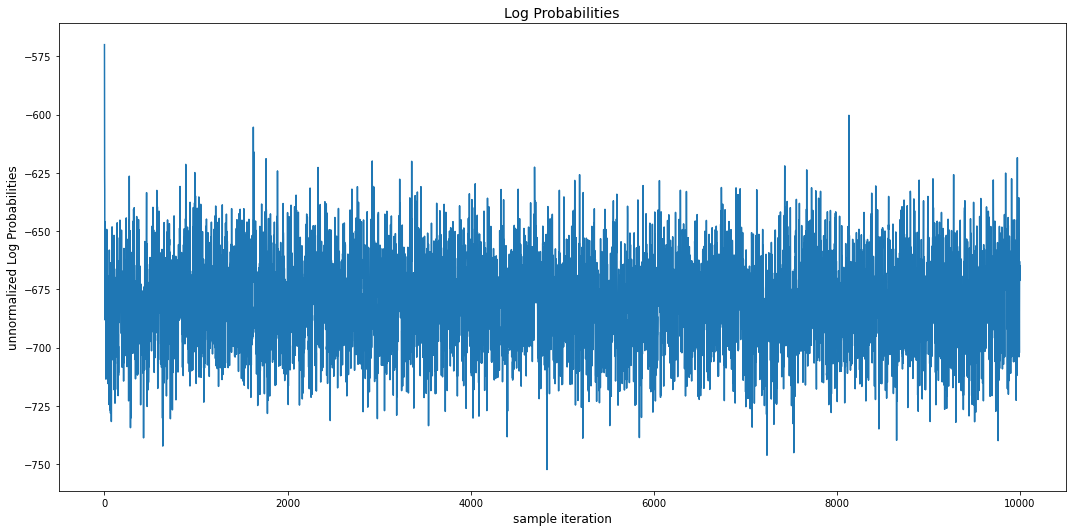

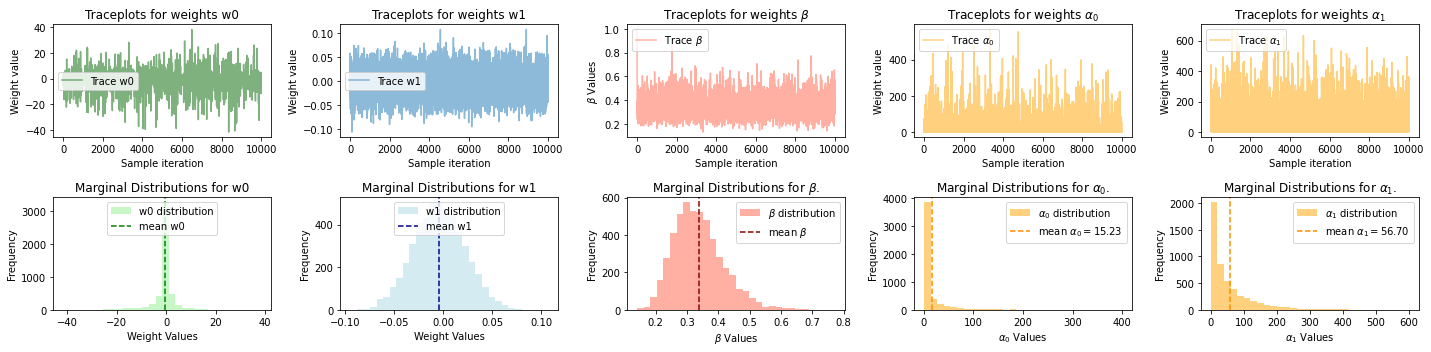

In [31]:
start = 0
n_iters = len(log_probs)  # Assuming log_probs is defined and gives the number of iterations

x_values = range(start, n_iters)

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 1, figsize=(15, 7.5))  # Adjust figsize as needed

# Plot for log probabilities
axs.plot(x_values, log_probs[start:])
axs.set_title('Log Probabilities', fontsize= 14)
axs.set_ylabel('unnormalized Log Probabilities', fontsize= 12)
axs.set_xlabel("sample iteration", fontsize= 12)

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("figures\\real\\ard_convergence_and_mixing_logprob.png",  facecolor='white', transparent=False)
# Show the plot
plt.show()


# ==============================================================
fig, axs = plt.subplots(2, 5, figsize=(20, 5))  # Adjust figsize as needed



axs[0, 0].plot(x_values, w_samples[start:, 0], label='Trace w0', alpha=0.5,  color='darkgreen')



axs[0, 0].set_title('Traceplots for weights w0')
axs[0, 0].legend(loc="center left")
axs[0, 0].set_xlabel("Sample iteration")
axs[0, 0].set_ylabel("Weight value")





# ==============================================================




axs[0,1].plot(x_values, w_samples[start:, 1], label='Trace w1', alpha=0.5)

axs[0,1].set_title('Traceplots for weights w1')
axs[0,1].legend(loc="center left")
axs[0,1].set_xlabel("Sample iteration")
axs[0,1].set_ylabel("Weight value")

# ==============================================================

# Traceplot for beta 


axs[0,2].plot(x_values, beta_samples[start:], alpha=0.5, label=r'Trace $\beta$', color='tomato')
axs[0,2].set_title(r'Traceplots for weights $\beta$')
axs[0,2].legend(loc="upper left")
axs[0,2].set_xlabel("Sample iteration")
axs[0,2].set_ylabel(r"$\beta$ Values")

# ==============================================================

axs[0,3].plot(x_values, alpha_samples[start:,0], alpha=0.5, label=r'Trace $\alpha_0$', color='orange')
axs[0,3].set_title(r'Traceplots for weights $\alpha_0$')
axs[0,3].legend(loc="upper left")
axs[0,3].set_xlabel("Sample iteration")
axs[0,3].set_ylabel("Weight value")

# ==============================================================

axs[0,4].plot(x_values, alpha_samples[start:,1], alpha=0.5, label=r'Trace $\alpha_1$', color='orange')
axs[0,4].set_title(r'Traceplots for weights $\alpha_1$')
axs[0,4].legend(loc="upper left")
axs[0,4].set_xlabel("Sample iteration")
axs[0,4].set_ylabel("Weight value")



# ==============================================================
burn_in = n_iters//2


axs[1,0].hist(w_samples[burn_in:, 0], alpha=0.5, color='lightgreen', label='w0 distribution', bins=30)
axs[1,0].axvline(np.mean(w_samples[burn_in:, 0]), color='green', linestyle='--', label='mean w0')




axs[1,0].set_title('Marginal Distributions for w0')
axs[1,0].legend(loc="upper center")
axs[1,0].set_xlabel("Weight Values")
axs[1,0].set_ylabel("Frequency")

# ==============================================================

# Marginal distribution for w1 with its mean line, in the same plot
axs[1,1].hist(w_samples[burn_in:, 1], alpha=0.5, color='lightblue', label='w1 distribution', bins=30)
axs[1,1].axvline(np.mean(w_samples[burn_in:, 1]), color='darkblue', linestyle='--', label='mean w1')


axs[1,1].set_title('Marginal Distributions for w1')
axs[1,1].legend(loc="upper center")
axs[1,1].set_xlabel("Weight Values")
axs[1,1].set_ylabel("Frequency")


# ==============================================================
# Marginal distribution for w0 with its mean line

axs[1,2].hist(beta_samples[burn_in:], alpha=0.5, color='tomato', label=r'$\beta$ distribution', bins=30)
axs[1,2].axvline(np.mean(beta_samples[burn_in:]), color='darkred', linestyle='--', label=r'mean $\beta$')





axs[1,2].set_title(r'Marginal Distributions for $\beta$.')
axs[1,2].legend(loc="upper right")
axs[1,2].set_xlabel(r"$\beta$ Values")
axs[1,2].set_ylabel("Frequency")


# ==============================================================










axs[1,3].hist(alpha_samples[burn_in:,0], alpha=0.5, color='orange', label=r'$\alpha_0$ distribution', bins=30)
axs[1,3].axvline(np.mean(alpha_samples[burn_in:,0]), color='darkorange', linestyle='--', label=r'mean $\alpha_0=$' + f"{np.mean(alpha_samples[burn_in:,0]):.2f}")

axs[1,3].set_title(r'Marginal Distributions for $\alpha_0$.')
axs[1,3].legend(loc="upper right")
axs[1,3].set_xlabel(r"$\alpha_0$ Values")
axs[1,3].set_ylabel("Frequency")


axs[1,4].hist(alpha_samples[burn_in:,1], alpha=0.5, color='orange', label=r'$\alpha_1$ distribution', bins=30)
axs[1,4].axvline(np.mean(alpha_samples[burn_in:,1]), color='darkorange', linestyle='--', label=r'mean $\alpha_1=$' + f"{np.mean(alpha_samples[burn_in:,1]):.2f}")

axs[1,4].set_title(r'Marginal Distributions for $\alpha_1$.')
axs[1,4].legend(loc="upper right")
axs[1,4].set_xlabel(r"$\alpha_1$ Values")
axs[1,4].set_ylabel("Frequency")

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("figures\\real\\ard_convergence_and_mixing.png",  facecolor='white', transparent=False)
# Show the plot
plt.show()





### Feature Relevance

- Look at Feature Relevance from: 
    - ARD
    - Linear Model
    - Ridge
    - Lasso



#### Feature Relevance from ARD

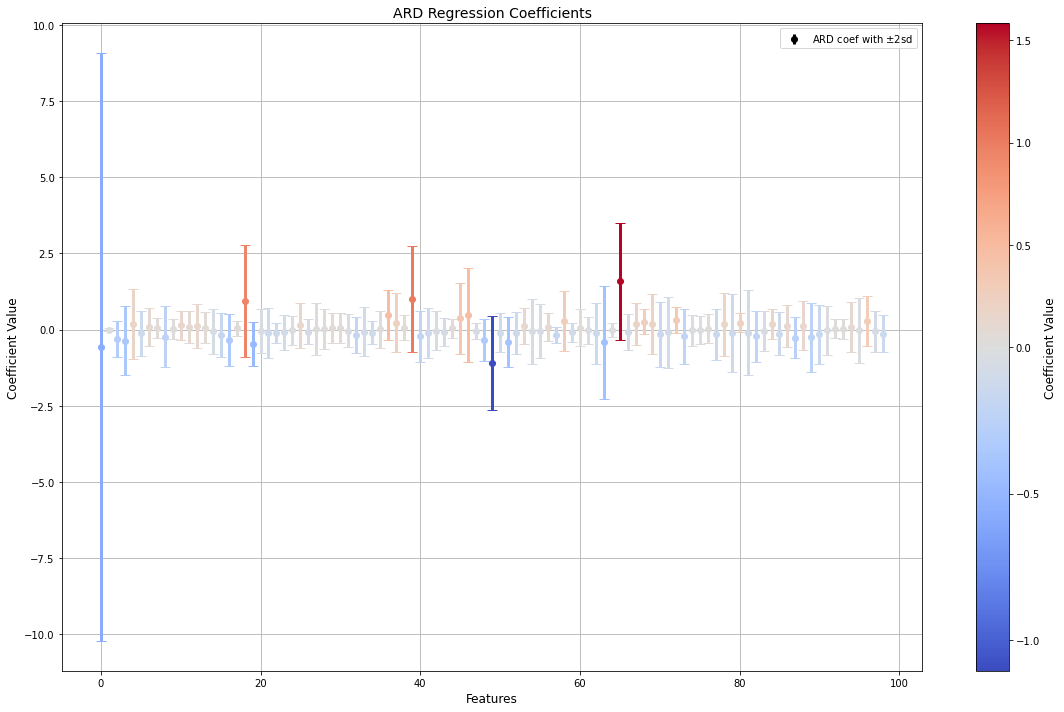

,3,0,1,2,4
coef value,-1.105285,-0.574169,0.940905,1.009999,1.582239
feature,49.000000,0.000000,18.000000,39.000000,65.000000


In [32]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import TwoSlopeNorm as TSNorm

fig, ax = plt.subplots(figsize=(16, 10))

w_samples_ = w_samples[n_iters//2:,:]

w_map, errors = (w_samples_.mean(axis=0), w_samples_.std(axis=0))



min_weight = np.min(w_map)
max_weight = np.max(w_map)

tsnorm = TSNorm(vmin=min_weight, vcenter=0, vmax=max_weight)

cmap = plt.get_cmap('coolwarm')

sm = ScalarMappable(cmap=cmap, norm=tsnorm)
sm.set_array([])
ax.errorbar([],[], yerr = [], color = "black", label=r'ARD coef with $\pm 2$sd',  fmt="o", elinewidth=3, capsize=5)
for i, (weight, error) in enumerate(zip(w_map, errors)):
    color = cmap((tsnorm(weight)))  # Map the normalized weight to a color
    ax.errorbar(i, weight, yerr=2*error, fmt="o", color=color, elinewidth=3, capsize=5)

ax.set_title('ARD Regression Coefficients', fontsize = 14)
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Coefficient Value', fontsize=12)
ax.set_xlabel('Features', fontsize = 12)
ax.set_ylabel('Coefficient Value', fontsize = 12)
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures\\real\\ard_parameter_analysis.png",  facecolor='white', transparent=False)
plt.show()

feature_ind =np.where(np.abs(w_map)>0.5)

pd.DataFrame( [w_map[feature_ind[0]],feature_ind[0]], index=["coef value", "feature"]).T.sort_values("coef value").T

#### Feature Relevance from Linear Regression (LR)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


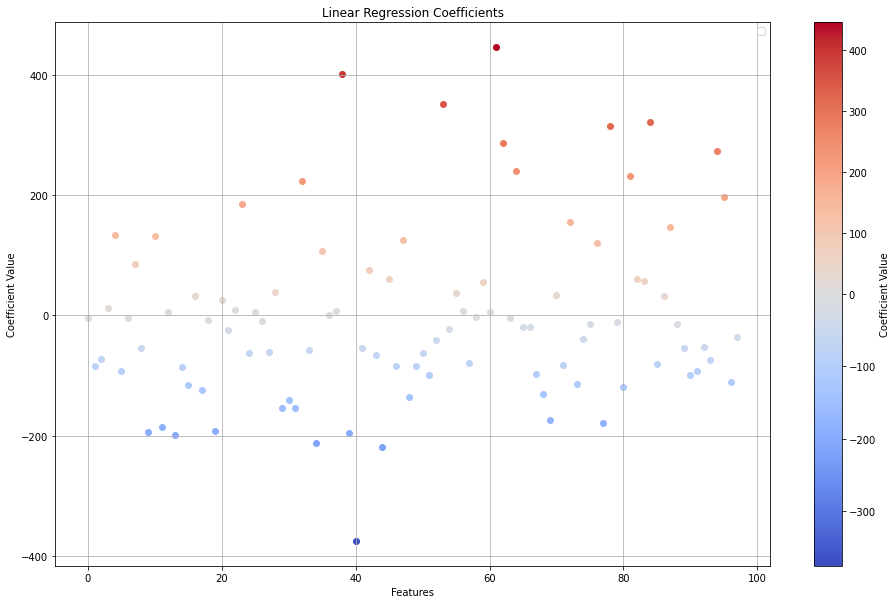

,39,43,34,13,38,9,19,11,76,68,...,32,80,63,93,61,77,83,52,37,60
coef value,-375.21817,-218.47319,-212.725755,-198.814196,-195.943854,-193.548986,-191.407463,-186.059739,-179.105661,-173.202164,...,223.96583,231.224766,240.184722,273.427129,286.319151,314.319608,321.994,350.862265,400.421202,446.192197
feature,40.00000,44.00000,34.000000,13.000000,39.000000,9.000000,19.000000,11.000000,77.000000,69.000000,...,32.00000,81.000000,64.000000,94.000000,62.000000,78.000000,84.000,53.000000,38.000000,61.000000


In [33]:
lm = LinearRegression(fit_intercept=True)

lm.fit(X_train_val,y_train_val)
fig, ax = plt.subplots(figsize=(16, 10))
min_weight = np.min(lm.coef_)
max_weight = np.max(lm.coef_)
tsnorm = TSNorm(vmin=min_weight, vcenter=0, vmax=max_weight)

cmap = plt.get_cmap('coolwarm')

sm = ScalarMappable(cmap=cmap, norm=tsnorm)
sm.set_array([])
for i, weight in enumerate(lm.coef_):
    color = cmap((tsnorm(weight)))  # Map the normalized weight to a color
    ax.scatter(i, weight, color=color)



ax.set_title('Linear Regression Coefficients')
plt.colorbar(sm, ax=ax, orientation='vertical', label='Coefficient Value')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficient Value')
ax.legend()
plt.grid(True)
plt.show()

feature_ind =np.where(np.abs(lm.coef_)>0.5)

pd.DataFrame( [lm.coef_[feature_ind[0]],feature_ind[0]], index=["coef value", "feature"]).T.sort_values("coef value").T

#### Feature Relevance from Ridge

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


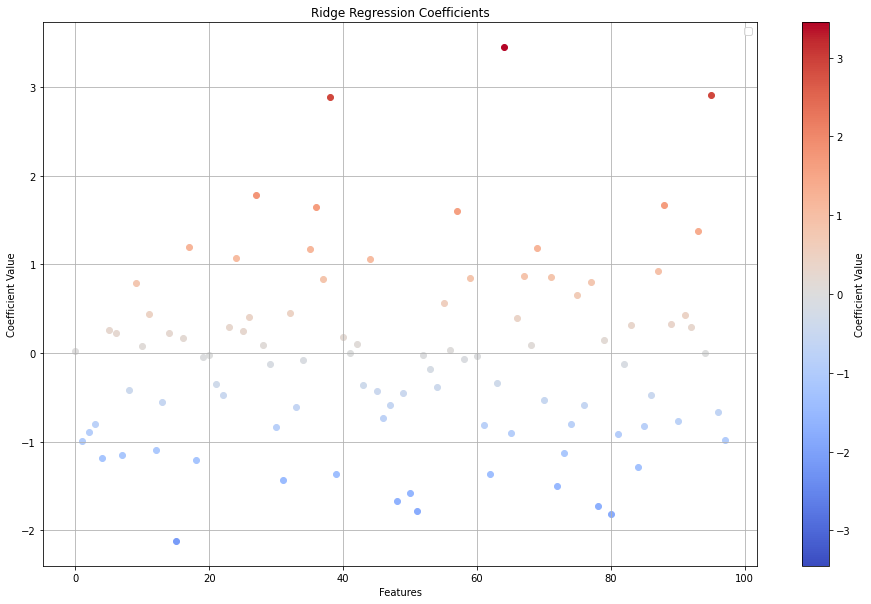

,8,45,26,44,24,25,38,14,31,20,...,35,9,52,28,17,50,12,19,53,32
coef value,-2.12187,-1.814419,-1.780911,-1.724163,-1.667374,-1.574416,-1.503115,-1.431129,-1.363588,-1.362259,...,1.188048,1.197878,1.380432,1.597154,1.648834,1.668472,1.779391,2.888959,2.908408,3.450827
feature,15.00000,80.000000,51.000000,78.000000,48.000000,50.000000,72.000000,31.000000,62.000000,39.000000,...,69.000000,17.000000,93.000000,57.000000,36.000000,88.000000,27.000000,38.000000,95.000000,64.000000


In [34]:
rlm = Ridge(fit_intercept=False, alpha = 0.1)

rlm.fit(X_train_val,y_train_val)
fig, ax = plt.subplots(figsize=(16, 10))
min_weight = np.min(rlm.coef_)
max_weight = np.max(rlm.coef_)
min_weight = min(min_weight,-abs(max_weight))
tsnorm = TSNorm(vmin=min_weight, vcenter=0, vmax=max_weight)

cmap = plt.get_cmap('coolwarm')

sm = ScalarMappable(cmap=cmap, norm=tsnorm)
sm.set_array([])
for i, weight in enumerate(rlm.coef_):
    color = cmap((tsnorm(weight)))  # Map the normalized weight to a color
    ax.scatter(i, weight, color=color)


ax.set_title('Ridge Regression Coefficients')
plt.colorbar(sm, ax=ax, orientation='vertical', label='Coefficient Value')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficient Value')
ax.legend()
plt.grid(True)
plt.show()

feature_ind =np.where(np.abs(rlm.coef_)>0.5)

pd.DataFrame( [rlm.coef_[feature_ind[0]],feature_ind[0]], index=["coef value", "feature"]).T.sort_values("coef value").T

#### Feature Relevance from Lasso

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


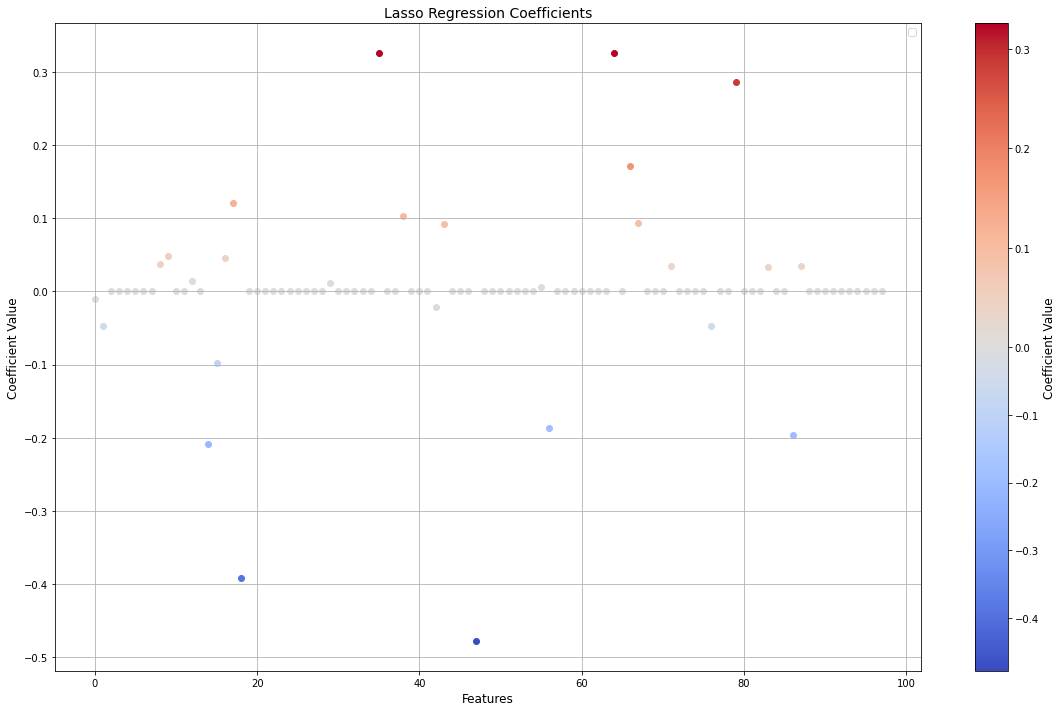

,3,1,0,5,4,2
coef value,-0.478088,-0.391821,-0.208248,0.285628,0.325218,0.325874
feature,47.000000,18.000000,14.000000,79.000000,64.000000,35.000000


In [35]:
from sklearn.linear_model import Lasso

llm = Lasso(fit_intercept=True, alpha = 0.1)

llm.fit(X_train_val,y_train_val)
fig, ax = plt.subplots(figsize=(16, 10))
min_weight = np.min(llm.coef_)
max_weight = np.max(llm.coef_)
min_weight = min(min_weight,-abs(max_weight))
tsnorm = TSNorm(vmin=min_weight, vcenter=0, vmax=max_weight)

cmap = plt.get_cmap('coolwarm')

sm = ScalarMappable(cmap=cmap, norm=tsnorm)
sm.set_array([])
for i, weight in enumerate(llm.coef_):
    color = cmap((tsnorm(weight)))  # Map the normalized weight to a color
    ax.scatter(i, weight, color=color)


ax.set_title('Lasso Regression Coefficients', fontsize = 14)
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', label='Coefficient Value')
cbar.set_label('Coefficient Value', fontsize=12)
ax.set_xlabel('Features', fontsize = 12)
ax.set_ylabel('Coefficient Value', fontsize = 12)
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("figures\\real\\lasso_parameter_analysis.png",  facecolor='white', transparent=False)
plt.show()
feature_ind =np.where(np.abs(llm.coef_)>0.2)

pd.DataFrame( [llm.coef_[feature_ind[0]],feature_ind[0]], index=["coef value", "feature"]).T.sort_values("coef value").T


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


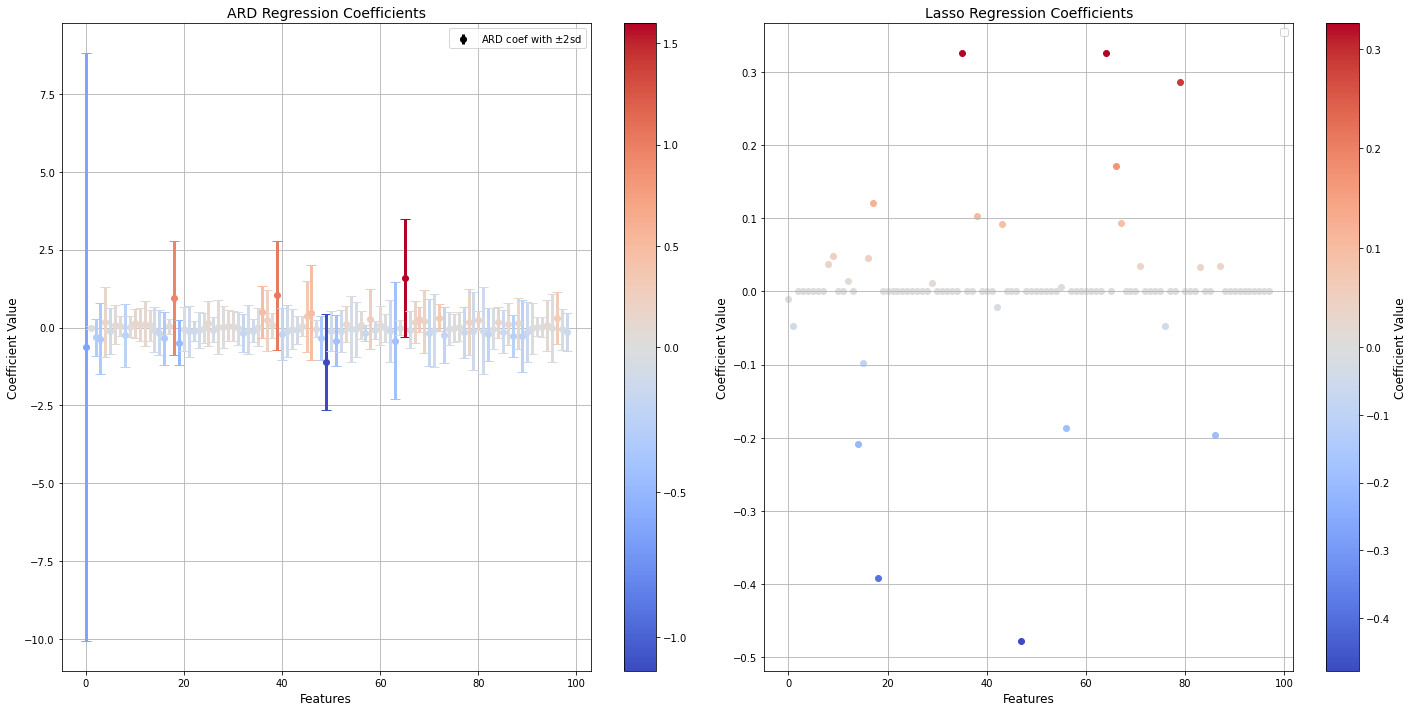

In [36]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)

w_samples_ = w_samples[500:,:]

w_map, errors = (w_samples_.mean(axis=0), w_samples_.std(axis=0))



min_weight = np.min(w_map)
max_weight = np.max(w_map)


tsnorm = TSNorm(vmin=min_weight, vcenter=0, vmax=max_weight)

cmap = plt.get_cmap('coolwarm')

sm = ScalarMappable(cmap=cmap, norm=tsnorm)
sm.set_array([])
ax[0].errorbar([],[], yerr = [], color = "black", label=r'ARD coef with $\pm 2$sd',  fmt="o", elinewidth=3, capsize=5)
for i, (weight, error) in enumerate(zip(w_map, errors)):
    color = cmap((tsnorm(weight)))  # Map the normalized weight to a color
    ax[0].errorbar(i, weight, yerr=2*error, fmt="o", color=color, elinewidth=3, capsize=5)

ax[0].set_title('ARD Regression Coefficients', fontsize = 14)
cbar = plt.colorbar(sm, ax=ax[0], orientation='vertical')
# cbar.set_label('Coefficient Value', fontsize=12)
ax[0].set_xlabel('Features', fontsize = 12)
ax[0].set_ylabel('Coefficient Value', fontsize = 12)
ax[0].legend()
ax[0].grid(True)



llm = Lasso(fit_intercept=True, alpha = 0.1)

llm.fit(X_train_val,y_train_val)

min_weight = np.min(llm.coef_)
max_weight = np.max(llm.coef_)
min_weight = min(min_weight,-abs(max_weight))
tsnorm = TSNorm(vmin=min_weight, vcenter=0, vmax=max_weight)

cmap = plt.get_cmap('coolwarm')

sm = ScalarMappable(cmap=cmap, norm=tsnorm)
sm.set_array([])
for i, weight in enumerate(llm.coef_):
    color = cmap((tsnorm(weight)))  # Map the normalized weight to a color
    ax[1].scatter(i, weight, color=color)


ax[1].set_title('Lasso Regression Coefficients', fontsize = 14)
cbar = plt.colorbar(sm, ax=ax[1], orientation='vertical')
cbar.set_label('Coefficient Value', fontsize=12)
ax[1].set_xlabel('Features', fontsize = 12)
ax[1].set_ylabel('Coefficient Value', fontsize = 12)
ax[1].legend()




ax[1].grid(True)
plt.tight_layout()
plt.savefig("figures\\real\\parameter_analysis.png",  facecolor='white', transparent=False)
plt.show()

